# Unit 3: Lesson 3: Project 4 Challenge:

## Logistic Regression, Ridge Regression, and Lasso Regression

(Scroll Down to Logistic Regression to skip previous work)

### Objective: Use Logistic Regression to Predict Property Crime
Build a regression model to predict property crimes using New York crime data. Will convert property_crime feature to property_crime_above_mean feature that is a categorical variable.  Cities will be separated into quantiles by population size, then cities will be assigned \"1\" for property_crime_above_mean if its property crime is above the mean for that quantile.

#### Statsmodels Logit Model:
- Provides summary information in easily readable form: coefficients, std error, z values, p-values, and confidence intervals.

- Does not allow you to set either L1 or L2 - to perform Ridge or Lasso Regression at the same time as performing Logistic Regression.

#### SKLearn Model (can apply Ridge or Logistic Regression at same time):
- Provides much less easily readable form:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
 intercept_scaling=1, max_iter=100, multi_class='warn',
 n_jobs=None, penalty='l2', random_state=None, solver='warn',
 tol=0.0001, verbose=0, warm_start=False)

- Allows you to set L1 or L2 to perform Ridge or Lasso Regression at the same time as performing Logistic Regression

### Objective: Use Ridge Regression to Reduce Multicollinearity in Features
Since the independent variables (murder_manslaughter, robbery, rape_2) used in this exercise are all crime related and since they are all within the defined category of \"violent crime\", there is a high likelihood of multicollinearity.  As a result of overfit, we see that coefficients arrived at by OLS become increasingly large - indicating overfit.

L2 regression: Ridge Regression **penalizes by the sum of squared coefficients** - high coefficients. Will use Ridge regression model as a variance minimizer to avoid overfit.

### Objective: Use Lasso Regression (Least Absolute Shrinkage and Selection Operator) to Select Features
For this crime data, there are few predictors for property crime, so a Lasso Regression may not be needed.  However, for hundreds or thousands of predictors, Lasso Regression is useful when you need to optimize processor time, or want to arrive at a simpler solution that's easier to interpret.

L1 Regression: Lasso Regression **penalizes by the sum of the absolute values of the coefficients**.  The penalty doesn't increase as swiftly with coefficient size as it does in Ridge Regression.

Lasso Regression optimizes the model by forcing small parameter estimates to be equal to zero, effectively dropping them from the model. This can prevent overfitting, and also works as an embedded feature selection method.

Data source: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls


Eva Rubin
December 2018


In [323]:
import numpy as np
import pandas as pd

import math
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

# scipy: import cross validation and KFold
import scipy
from scipy import stats
from scipy.stats import boxcox

# sklearn: import cross validation and KFold
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# sklearn: import gridsearch to identify optimal lambda - regularization parameter by cross val
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# matplotlib and sns plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


# Help
# https://pythonfordatascience.org/linear-regression-python/

In [4]:
#plt.rcParams['figure.figsize'] = (50.0, 20.0)
#plt.rcParams.update({'font.size': 22})

In [2]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
df_orig = pd.read_csv(data_path, delimiter= ',', header=None)

In [3]:
# Look at structure of df_orig
df_orig.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Table 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
5,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
6,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
7,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
8,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
9,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
# Get the number of rows and columns
df_orig.shape

(356, 13)

In [5]:
# Get column names
df_orig.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
dtype: object

In [6]:
# Rename columns
df_orig.rename(columns={0: 'city', 1: 'pop_size', 2: 'violent_crime', 3: 'murder_manslaughter',
       4: 'rape_1', 5: 'rape_2', 6: 'robbery', 7: 'aggravated_assault', 8: 'property_crime', 
       9: 'burglary', 10: 'larceny_theft', 11: 'mv_theft', 12: 'arson_3'}, inplace=True)

df_orig.columns


Index(['city', 'pop_size', 'violent_crime', 'murder_manslaughter', 'rape_1',
       'rape_2', 'robbery', 'aggravated_assault', 'property_crime', 'burglary',
       'larceny_theft', 'mv_theft', 'arson_3'],
      dtype='object')

In [7]:
# Check for samples with null records for property crime since it is dependent variable
df_orig.loc[df_orig['property_crime'] == '0']

,city,pop_size,violent_crime,murder_manslaughter,rape_1,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
191,Manchester Village,"1,688",0,0,NaN,0,0,0,0,0,0,0,0
213,New Berlin Town,"1,622",0,0,NaN,0,0,0,0,0,0,0,0
261,Port Byron Village,"1,274",0,0,NaN,0,0,0,0,0,0,0,0
292,Schoharie Village,872,0,0,NaN,0,0,0,0,0,0,0,0
300,Shortsville Village,"1,437",0,0,NaN,0,0,0,0,0,0,0,0
324,Tuxedo Park Village,615,0,0,NaN,0,0,0,0,0,0,0,0


In [8]:
# Drop above samples from data set since all categories are 0 and they represent a small sample
# possible missing reports or just no crimes whatsoever in small towns?

df_orig = df_orig[df_orig['property_crime'] > '0']


In [9]:
# create new df copy and Remove rape_1 column and remove first 5 unwanted rows and last 3 unwanted rows.
df = df_orig.drop('rape_1', axis=1).drop(df_orig.index[0:5]).drop(df_orig.index[-3:]).copy()

In [10]:
df.head(10)


,city,pop_size,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
9,Albion Village,"6,388",23,0,3,4,16,223,53,165,5,NaN
10,Alfred Village,"4,089",5,0,0,3,2,46,10,36,0,NaN
11,Allegany Village,"1,781",3,0,0,0,3,10,0,10,0,0
12,Amherst Town,"118,296",107,1,7,31,68,"2,118",204,"1,882",32,3
13,Amityville Village,"9,519",9,0,2,4,3,210,16,188,6,1
14,Amsterdam,"18,182",30,0,0,12,18,405,99,291,15,0
15,Arcade Village,"2,053",0,0,0,0,0,39,3,35,1,0
16,Ardsley Village,"4,523",5,0,0,3,2,33,4,28,1,0
17,Asharoken Village,658,0,0,0,0,0,2,0,2,0,0
18,Attica Village,"2,522",2,0,0,0,2,5,0,4,1,0


In [11]:
# Clean up features

# Remove commas in pop size numbers
df['pop_size'] = df['pop_size'].str.replace(',', '')

# Remove commas in numbers
df['property_crime'] = df['property_crime'].str.replace(',', '')

# Remove commas in numbers
df['robbery'] = df['robbery'].str.replace(',', '')

# Remove commas in numbers
df['violent_crime'] = df['violent_crime'].str.replace(',', '')

# Remove commas in numbers
df['rape_2'] = df['rape_2'].str.replace(',', '')

# Remove commas in numbers
df['aggravated_assault'] = df['aggravated_assault'].str.replace(',', '')

# Remove commas in numbers
df['burglary'] = df['burglary'].str.replace(',', '')

# Remove commas in numbers
df['larceny_theft'] = df['larceny_theft'].str.replace(',', '')

# Remove commas in numbers
df['mv_theft'] = df['mv_theft'].str.replace(',', '')


In [12]:
# Convert type to int (from string)

df['pop_size'] = df['pop_size'].astype(int)

df['property_crime'] = df['property_crime'].astype(int)

df['robbery'] = df['robbery'].astype(int)

df['violent_crime'] = df['violent_crime'].astype(int)

df['murder_manslaughter'] = df['murder_manslaughter'].astype(int)

df['rape_2'] = df['rape_2'].astype(int)

df['aggravated_assault'] = df['aggravated_assault'].astype(int)

df['burglary'] = df['burglary'].astype(int)

df['larceny_theft'] = df['larceny_theft'].astype(int)

df['mv_theft'] = df['mv_theft'].astype(int)

df['arson_3'] = df['mv_theft'].astype(int)


# Convert to str
df['city'] = df['city'].astype(str)


In [13]:
# Convert new features to catgorical: murder, robbery for possible later use

df['murder_manslaughter_cat'] = np.where(df['murder_manslaughter'] == 0, 0, 1)

df['robbery_cat'] = np.where(df['robbery'] == 0, 0, 1)


In [14]:
df.dtypes

city                       object
pop_size                    int64
violent_crime               int64
murder_manslaughter         int64
rape_2                      int64
robbery                     int64
aggravated_assault          int64
property_crime              int64
burglary                    int64
larceny_theft               int64
mv_theft                    int64
arson_3                     int64
murder_manslaughter_cat     int64
robbery_cat                 int64
dtype: object

In [15]:
df.head()

,city,pop_size,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3,murder_manslaughter_cat,robbery_cat
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,5,0,1
10,Alfred Village,4089,5,0,0,3,2,46,10,36,0,0,0,1
11,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0,0,0
12,Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,32,1,1
13,Amityville Village,9519,9,0,2,4,3,210,16,188,6,6,0,1


### Ordinary Least Squares

#### Property Crime is a category of crime that subsumes burglary, larceny, and mv, so they are not included in OLS.  Will include population size and broad category of violent crime that subsumes murder/manslaughter, rape, robbery, and aggravated assault to get.

#### R-squared is very high at .999, so will need to determine which features can be removed from regression, and which features predict property crime.

#### Will check linearity of dependent to independent variables, multi-variate distribution (error from model is distributed normally), homoscedasticity, and multicolinearity and then re-run OLS.


In [17]:
#Ordinary Least Squares using statmodels formula (smf)

# requires import statsmodels.formula.api as smf

lm_1 = smf.ols(formula = "property_crime ~ pop_size + murder_manslaughter + rape_2 + aggravated_assault + robbery", data = df).fit()
lm_1.summary()

# R-squared - describes how much of dependent variable outcome is explaind by independent variables

# Coef - dependent variable would already be at this level without other variables added.
# Where "0" starts. Don't give it that much weight.

# Coef can represent a lot of bias. Negative coefficients - if there's a safer relationship
# (in this case less property crime) - it shows relativity.

# Coef and y intercept: coef is in the unit that's represented in the data (cm, or %, or feet, etc).

# When each additional unit of population size occurs, property crime goes up by 0.0131
# When each additional unit of murder manslaughter occurs, property crime goes up by 42.0490
# When each additional unit of rape_2 occurs, property crime goes up by 64.6682
# When each additional unit of aggravated_assault occurs, property crime goes down by -3.4565
# When each additional unit of robbery occurs, property crime goes down by 2.9138

# pay attention to confidence intervals - you can predict that the property crime is going to be affected
# as coef's tell you with the confidence level noted in p-value


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.862e+04
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        21:36:31   Log-Likelihood:                -2290.2
No. Observations:                 335   AIC:                             4592.
Df Residuals:                     329   BIC:                             4615.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              30.1250     15.445      1.951      0.052      -0.258      60.508
pop_size                0.0131      0.001     16.018      0.000       0.011       0.015
murder_manslaughter    42.0490     15.189      2.768      0.006      12.170      71.928
rape_2                 64.6682      4.020     16.085      0.000      56.759      72.577
aggravated_assault     -3.4565      0.628     -5.506      0.000      -4.691      -2.222
robbery                 2.9138      1.065      2.736      0.007       0.819       5.009
==============================================================================
Omnibus:                      282.750   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10786.090
Skew:                           3.157   Prob(JB):                         0.00
Kurtosis:                      30.072   Cond. No.                     5.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check Linearity and Data Distributions: Pair plot

#### Property Crime is a category of crime that subsumes burglary, larceny, and mv, so they are not included in linearity check.  Will check linearity with population size and broad category of violent crime that subsumes murder/manslaughter, rape, robbery, and aggravated assault.

#### There appears to be a linear relationship between violent crime and property crime, and between property crime and population size.

#### However, confidence in relationship between property crime and population size seems poorer than between property crime and violent crime.

#### New York outlier is potentially problematic.

#### Data distributions are not normal


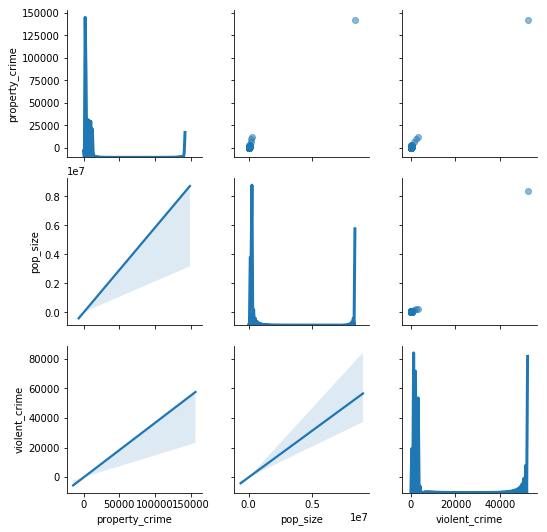

In [18]:
#sns.pairplot(df[['property_crime', 'pop_size', 'violent_crime']].dropna(how = 'any', axis = 0))

# Make a scatterplot Matrix.
g = sns.PairGrid(df[['property_crime', 'pop_size', 'violent_crime']].dropna(how = 'any', axis = 0), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()


### Feature Engineering: New York appears to be a distinct outlier, will remove now to see how it affects error/residual plot.

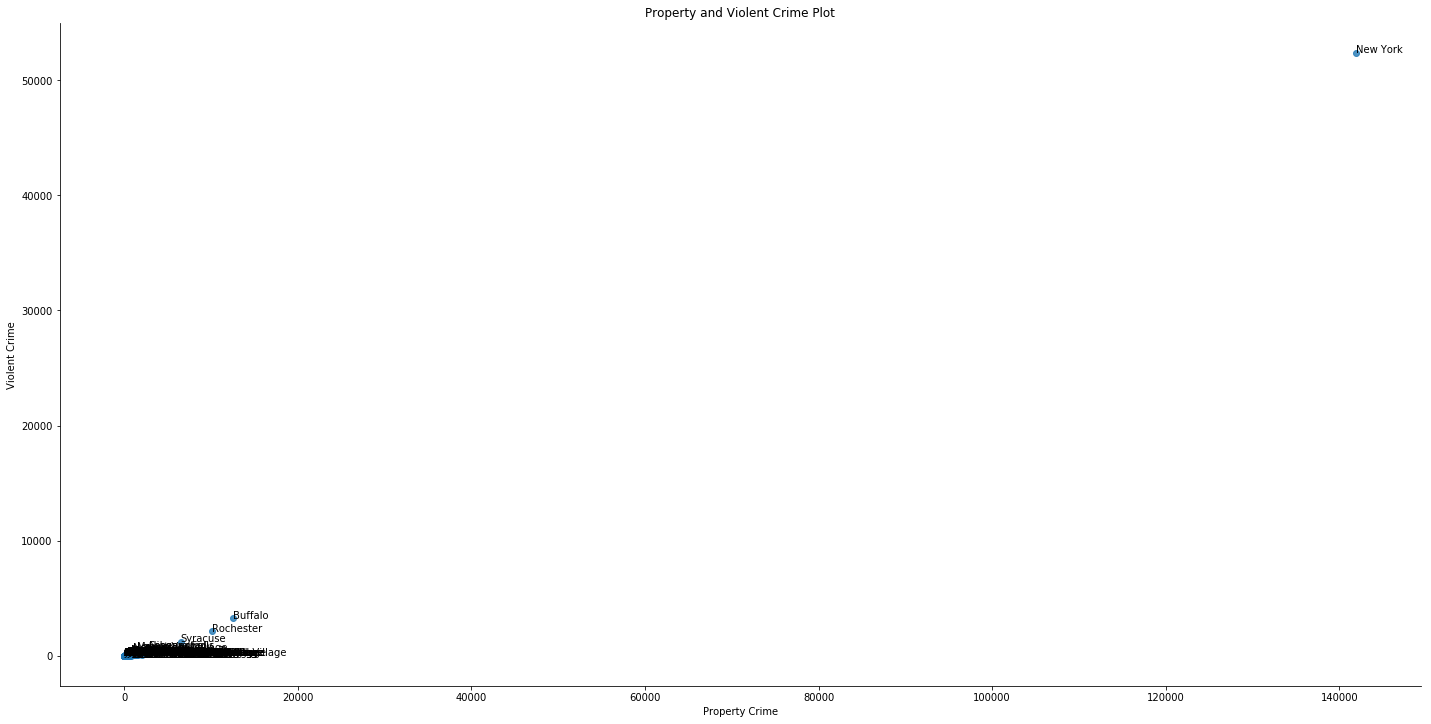

In [19]:
# Show outliers and label them

# Annotated scatter plot with no regression line (fit_reg=False)
# https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df['property_crime'], df['violent_crime'], df['city'], plt.gca()) 

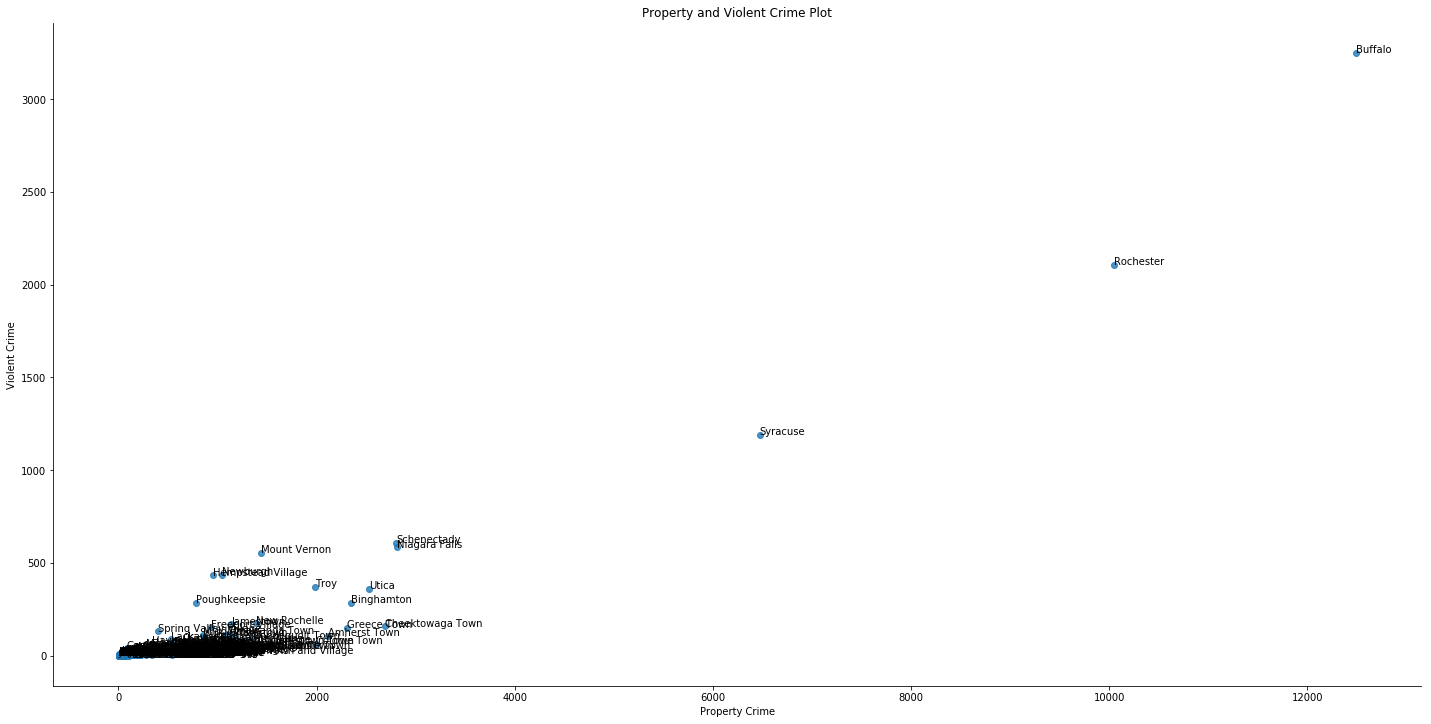

In [20]:
# Remove NY outlier

# create new df without outlier for city: New York
df_ny_removed = df[df['city'] != 'New York']

# show new annotated scatter plot without new york

ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df_ny_removed,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df_ny_removed['property_crime'], df_ny_removed['violent_crime'], df_ny_removed['city'], plt.gca()) 


### Feature Engineering: Now Buffalo, Rochester, Syracuse appear to be outliers.  But are they?

#### To determine statistical outliers and whether they should be removed from analysis, will define quartiles and interquartile range so that all data points (cities) that remain outside of this range can be removed.


In [21]:
# Quartiles and Interquartile Range (IQR)
q75, q25 = np.percentile(df['pop_size'].dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

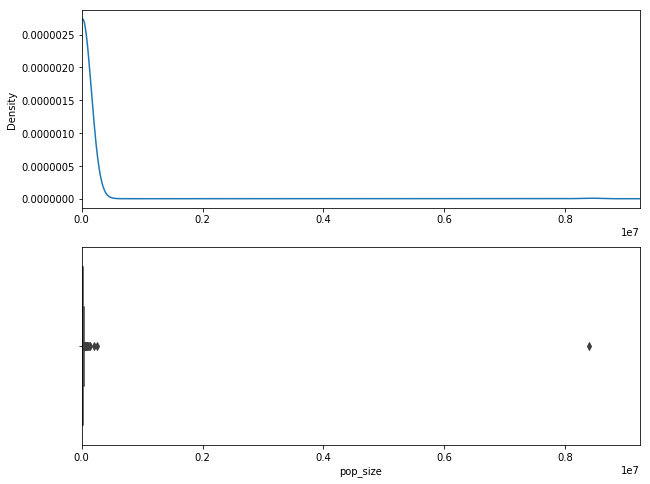

In [22]:
# Raw population distribution kde and boxplot
i = 'pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i]);


In [23]:
# Do a log transform to normalize population size and create new feature called log_pop_size

# Remove any zeros (otherwise we get (-inf)
df.loc[df['pop_size'] == 0, 'pop_size'] = np.nan


# Drop NA
df.dropna(inplace=True)

# Log Transform
df['log_' + i] = np.log(df[i])

In [24]:

# Convert back to int (in cell above it gets converted to float)
df['pop_size'] = df['pop_size'].astype(int)

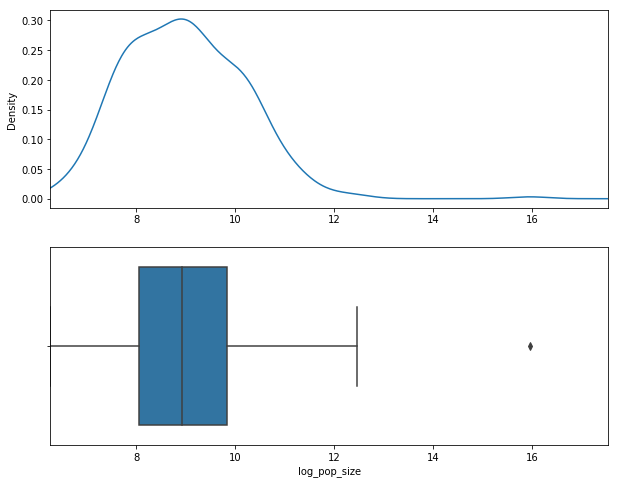

In [25]:
# plot log transformed population and boxplot to show effect on normality in log_pop_size
# (could also try other transformations and do a Shapiro test to quantify normality as compared to theoretical ideal)

i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
 
ax = df[i_log].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
sns.boxplot(x=df[i_log]);

In [26]:
# Get quartiles and interquartile range in log transformed population size
q75, q25 = np.percentile(df['log_pop_size'].dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

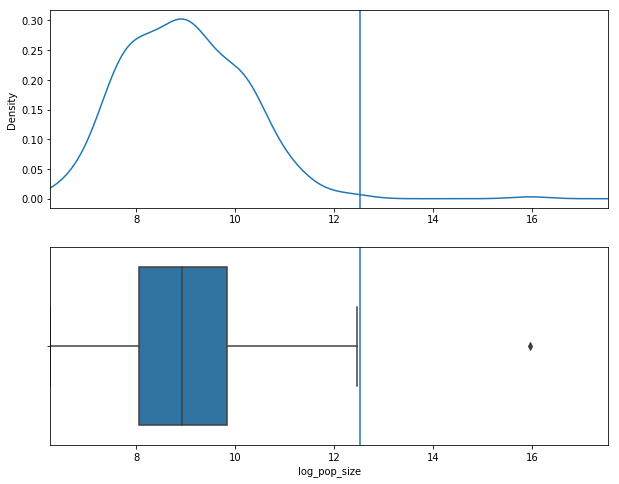

In [27]:
# Show outliers that fall outside of IQR * 1.5: only New York city is determined an outlier.
i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = df[i_log].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
sns.boxplot(x=df[i_log])
plt.axvline(x=min)
plt.axvline(x=max);

In [28]:
# Define outlier in log transformed pop_size and create new variable called outlier

df['outlier'] = 0

# Convert to float to avoid data type conversion warnings
df['outlier'] = df['outlier'].astype(int)
 
df.loc[df[i_log] < min, 'outlier'] = 1
df.loc[df[i_log] > max, 'outlier'] = 1


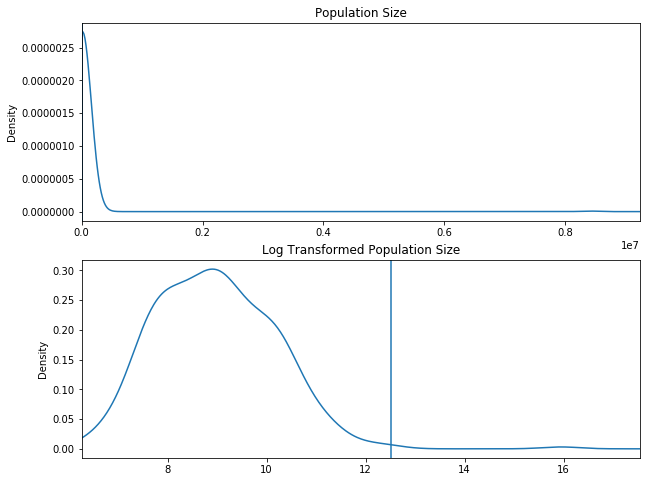

In [29]:
# Show differences in distribution of raw vs. log transformed population size data

i = 'pop_size'
i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
plt.title('Population Size')
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
plt.title('Log Transformed Population Size')

ax = df[i_log].plot(kind='kde');

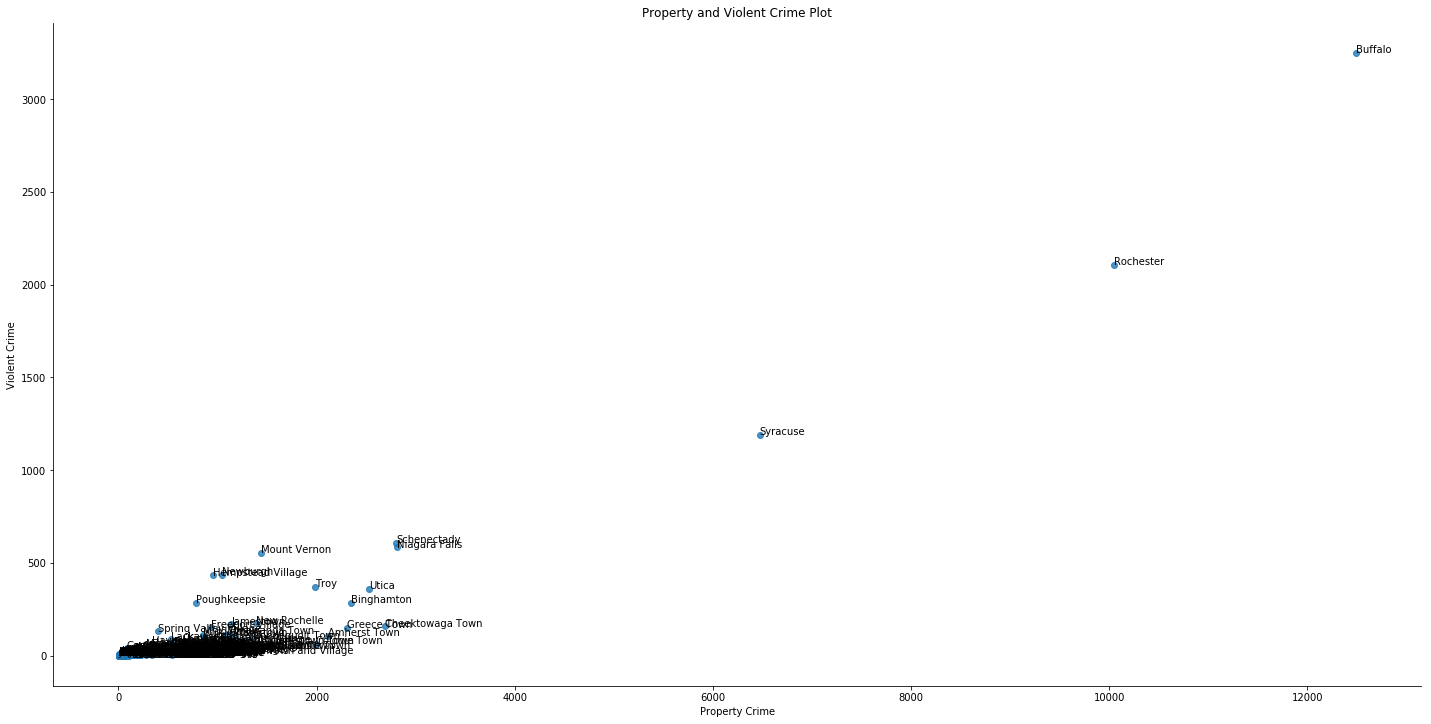

In [30]:
# create new df without outlier New York and plot property crime against violent crime
df_outliers_removed = df[df['outlier'] != 1].copy()


# show new annotated scatter plot without new york

ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df_outliers_removed,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df_outliers_removed['property_crime'], df_outliers_removed['violent_crime'], df_outliers_removed['city'], plt.gca()) 


In [31]:
# Change in number of rows and columns
df_outliers_removed.shape

(334, 16)

## Recheck Linearity: Linearity of independent variables to dependent variable

#### This time linearity check includes all crimes subsumed by violent crime to look at linearity between property crime and murder/manslaughter, rape, aggravated assault, and robbery.

#### Population size appears to have strongest linear relationship independent variable with best confidence

#### After population size, independent variables aggravated assault, rape, and robbery appear to have strongest linear relationship with best confidence

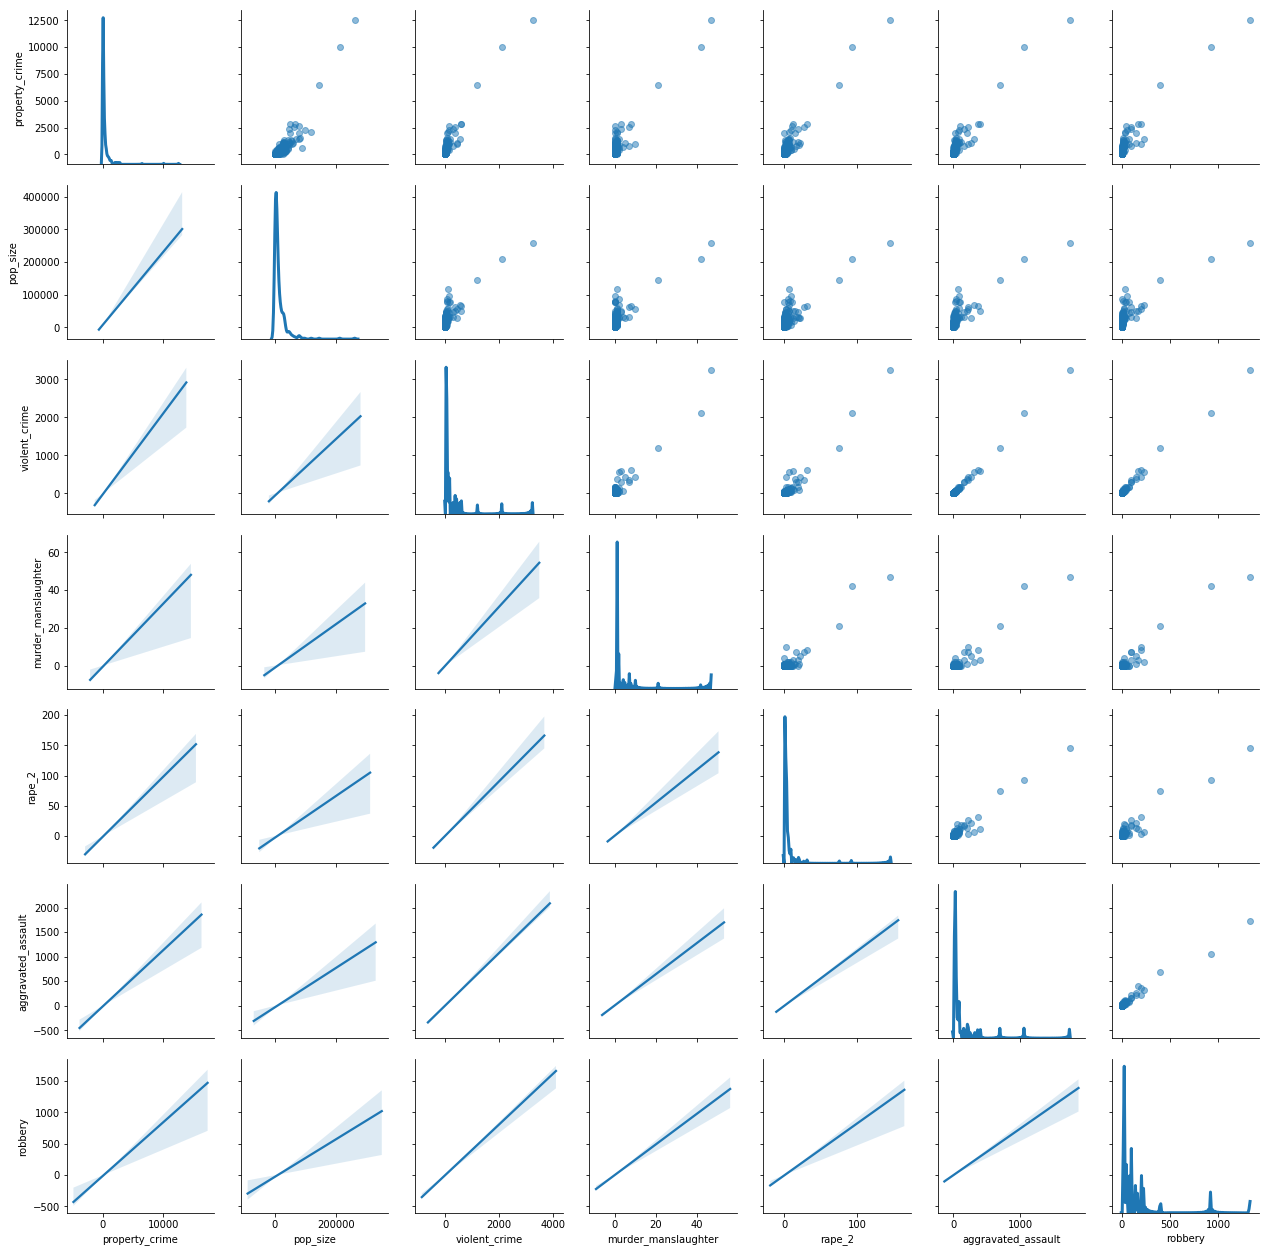

In [32]:
# Check out linearity between property crime and individual violent crimes now that new york outlier is removed
# Make a scatterplot Matrix.
g = sns.PairGrid(df_outliers_removed[['property_crime', 'pop_size', 'violent_crime', 'murder_manslaughter', 
                                'rape_2', 'aggravated_assault', 'robbery']].dropna(how = 'any', axis = 0), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

### R-squared improved, but is still high at .965

### y intercept now negative after removing pop_size outliers, but since there are multiple independent variables having different effects and indication of strong multicolinearity in condition number, will do PCA to identify best components for analysis.

In [33]:
# requires import statsmodels.formula.api as smf

lm_2 = smf.ols(formula = "property_crime ~ pop_size + murder_manslaughter + aggravated_assault + rape_2 + robbery", data = df_outliers_removed).fit()
lm_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          2.79e-237
Time:                        21:38:13   Log-Likelihood:                -2227.4
No. Observations:                 334   AIC:                             4467.
Df Residuals:                     328   BIC:                             4490.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -17.9310     13.713     -1.308      0.192     -44.907       9.045
pop_size                0.0162      0.001     21.835      0.000       0.015       0.018
murder_manslaughter     9.4950     13.152      0.722      0.471     -16.377      35.367
aggravated_assault      1.3640      0.676      2.016      0.045       0.033       2.695
rape_2                 33.1229      4.369      7.581      0.000      24.528      41.718
robbery                 0.9763      0.916      1.066      0.287      -0.826       2.778
==============================================================================
Omnibus:                       68.484   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              997.710
Skew:                           0.283   Prob(JB):                    2.24e-217
Kurtosis:                      11.448   Cond. No.                     3.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Will Use PCA to identify which components explain most of variance.

### One component explains 80.48% of variance.  Will identify variables in that component and use for analysis.

In [34]:
# PCA: reduce dimensionality and prevent multi-colinearity - I may have picked the wrong variables, so this will help me
# identify the right variables to use (can't include categorical variables - axis=1 because it's a city

# have to drop city because it's not numerical, drop depedent/target variable: property_crime
# drop pop_size (keep log_pop_size)
# drop categorical variables: murder_manslaughter and robbery
# drop outliers

df_no_city = df_outliers_removed.drop(['city', 'property_crime', 'log_pop_size'], axis=1).dropna()

X = StandardScaler().fit_transform(df_no_city)
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.80482732 0.10019881 0.05616384 0.02238086 0.00608812]


In [37]:
# Eigenvalues and eigenvector - try to find the line that best fits the data
# by minimizing the distance between the line and the data points and maximizing the variance explained by the data
# the numbers associated with final points for this line for this component
Y_sklearn[:, 0]

array([-4.10661766e-01, -7.42974359e-01, -9.49898793e-01,  2.98768615e+00,
       -4.81765803e-01, -1.18834638e-01, -9.34686992e-01, -7.39324877e-01,
       -9.77879957e-01, -9.38668337e-01,  1.41617337e+00, -7.65391600e-01,
       -6.79044232e-01, -6.90621421e-01,  9.61093335e-02, -5.60399748e-01,
       -5.04574969e-01, -1.31634755e-01,  3.97779210e+00, -9.62626156e-01,
       -6.71266702e-01, -9.67443605e-01, -9.38536109e-01, -9.45762441e-01,
       -7.60720655e-01, -9.51604363e-01, -8.86648761e-01,  9.35358634e-01,
       -3.82927492e-03, -8.62739786e-01, -9.68556876e-01,  4.06792048e+01,
       -9.04625892e-01, -9.20046543e-01, -9.18304153e-01, -4.07291276e-01,
       -3.76230266e-01, -8.76043893e-01, -7.93453110e-01, -6.90875186e-01,
       -9.76706074e-01, -3.13672532e-01, -9.41115445e-01, -8.67743101e-01,
       -9.73370731e-01, -7.56975061e-01, -9.17195702e-01, -7.59094879e-01,
       -9.37025089e-01,  3.09266530e+00, -8.78233363e-01, -8.79865904e-01,
       -2.11762843e-01,  

### PCA Component:

#### Aggravated Assault and Robbery violent crimes appear to explain the greatest level of variance in the model


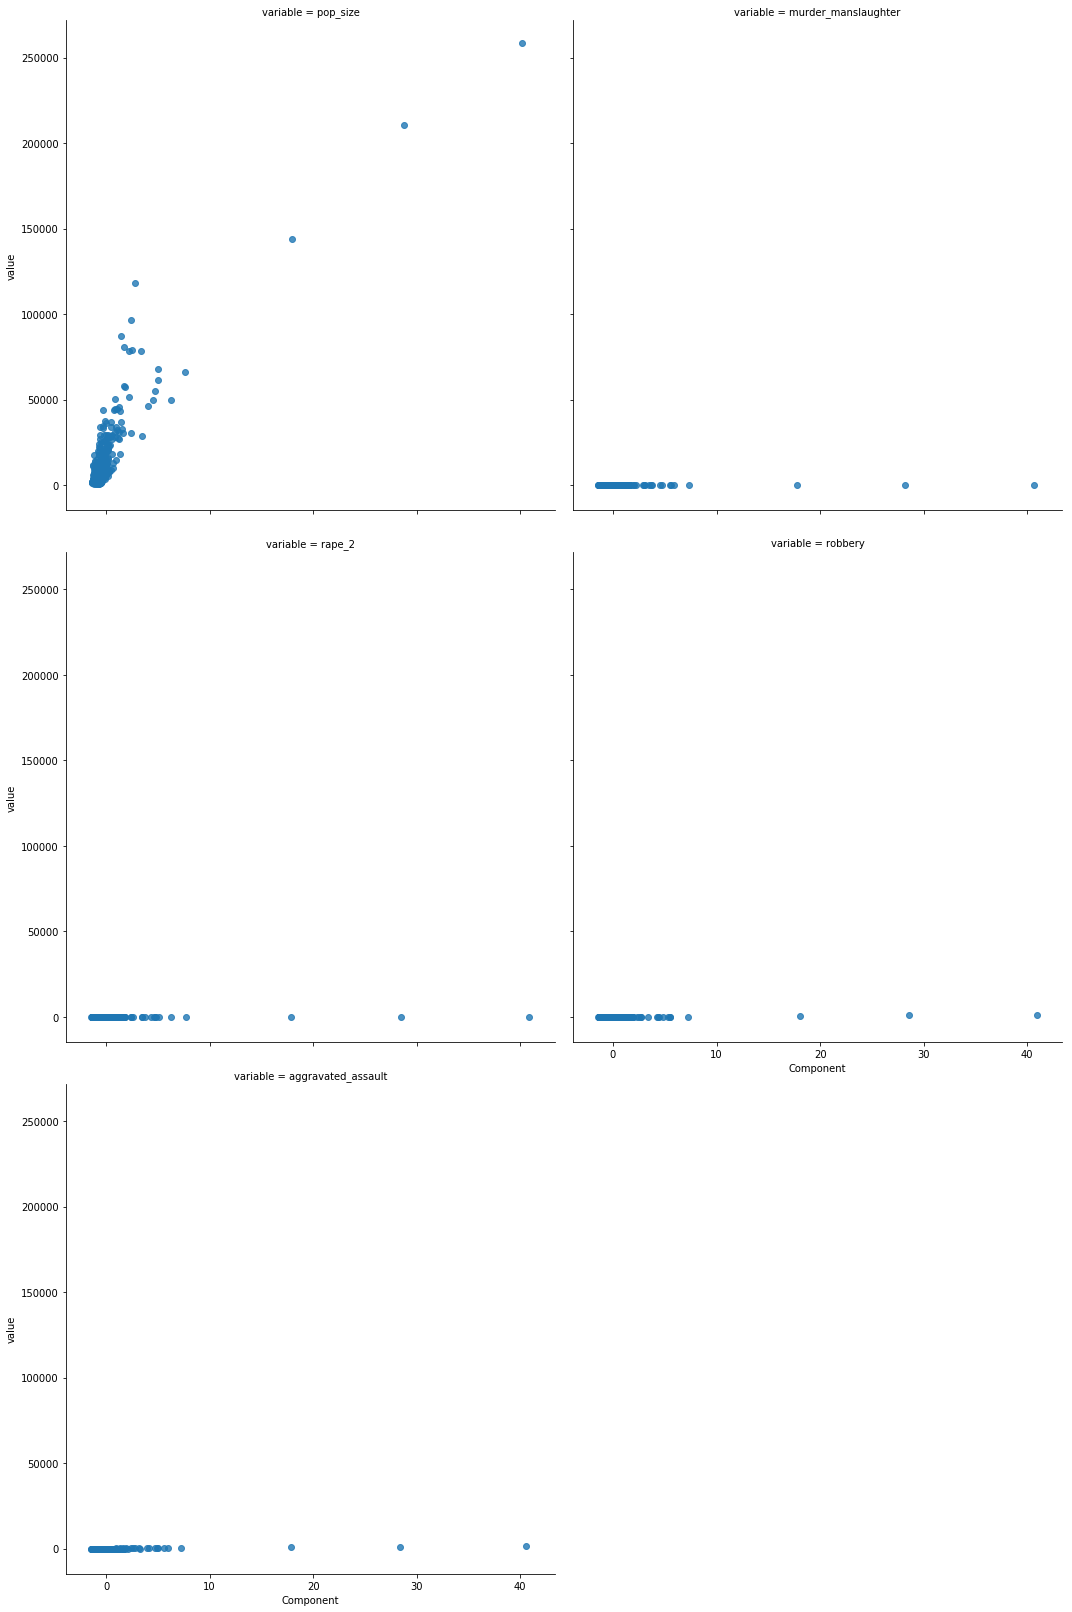

In [38]:
# DO OLS WITH most linear

# Identify what's in the components that's responsible for result:
# Remove first variable (property crime) because it is dependent
# Remove categorical variables, pop_size_squared, and arson_3 because types don't match

data_to_plot = df_no_city.drop(['violent_crime', 'murder_manslaughter_cat', 'robbery_cat', 
                                'burglary', 'larceny_theft', 'mv_theft',
                               'arson_3', 'outlier'], axis=1)
data_to_plot['Component'] = Y_sklearn[:,0]
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", col_wrap=2, height=7.5, aspect=1)
g = g.map(
  sns.regplot,
  "Component",
  "value",
  x_jitter=.49,
  y_jitter=.49,
  fit_reg=False
)


plt.show()


### Check Normality of Errors in Residual Plot
#### Dependent variable: property_crime
#### Independent variables: robbery, and aggravated_assault

In [39]:
# Extract predicted values.

# Reset x and y for regression since removed outlier and it changed shape of df after setting x and y:

# Instantiate the model.
lin_regr = linear_model.LinearRegression()

# Fit model to data.
y_residual = pd.DataFrame(df_outliers_removed['property_crime'])
x_residual = pd.DataFrame(df_outliers_removed[['aggravated_assault', 'robbery']])

lin_regr.fit(x_residual, y_residual)

# Extract predicted and actual values.
predicted = lin_regr.predict(x_residual).ravel()
actual = df_outliers_removed['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted


/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### Residual Error Plot indicates multivariate normality is an issue.

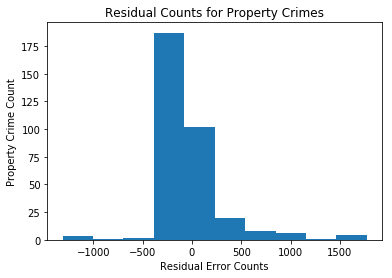

In [40]:
# Residual Error Plot
plt.hist(residual)
plt.title('Residual Counts for Property Crimes')
plt.xlabel('Residual Error Counts')
plt.ylabel('Property Crime Count')
plt.show()

### Regression

#### R-squared continues to be high even with reduced features. Overfit likely.
#### Condition number continues to be high, indicating continued likelihood of multicolinearity

In [42]:
lm_3 = smf.ols(formula = "property_crime ~ pop_size", data = df_outliers_removed).fit()
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1719.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          2.56e-133
Time:                        21:40:59   Log-Likelihood:                -2485.4
No. Observations:                 334   AIC:                             4975.
Df Residuals:                     332   BIC:                             4982.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -199.3481     26.607     -7.492      0.000    -251.688    -147.008
pop_size       0.0373      0.001     41.459      0.000       0.036       0.039
==============================================================================
Omnibus:                       96.106   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4142.118
Skew:                           0.230   Prob(JB):                         0.00
Kurtosis:                      20.246   Cond. No.                     3.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Data is not linear as indicated by Error Residuals Probability Plot


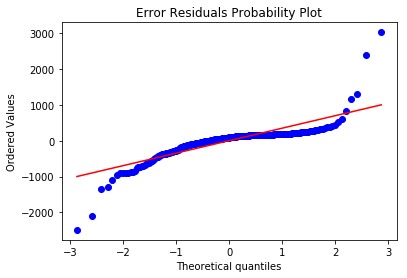

In [43]:
# Probability Plot to view normality (blue data should fit to red line of expected error)
stats.probplot(lm_3.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

### Data is heteroscedastic as indicated by Residual Error Plot

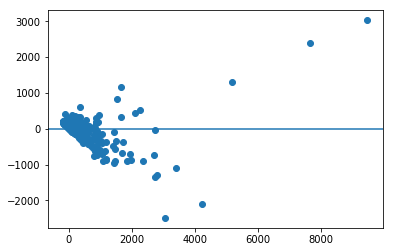

In [44]:
# Residual Error Plot
resid_3 = lm_3.resid
plt.axhline(y=0)
plt.scatter(lm_3.predict(), resid_3);

### Quanitify normality in Kolmogorov-Smirnov Test:

In [46]:
# KS test to quantify normality
# null hypothesis rejected: residual error is not drawn from "same population" as normally distributed population
#(theoretical norm in this case).  Error is not normally distributed.

print('Kolmogorov-Smirnov test:')
print(stats.kstest(lm_3.resid, 'norm'))

Kolmogorov-Smirnov test:
KstestResult(statistic=0.6391006085694875, pvalue=0.0)


In [47]:
# Fix non-normality
# https://stattrek.com/regression/linear-transformation.aspx?tutorial=ap

### Feature Engineering: Address normality of independent variable, robbery:

#### Log Transformation best fit and saved as new feature: log_robbery
#### Distribution remains skewed

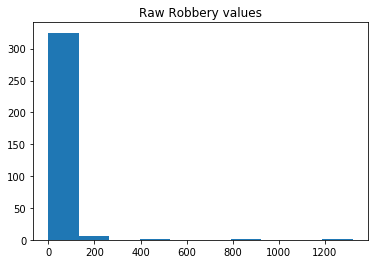

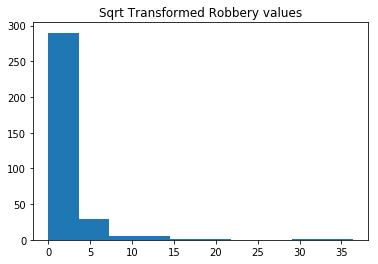

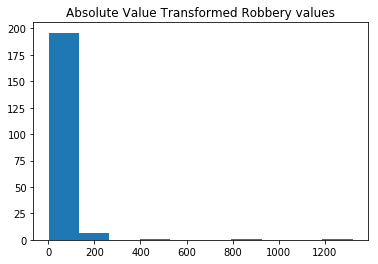

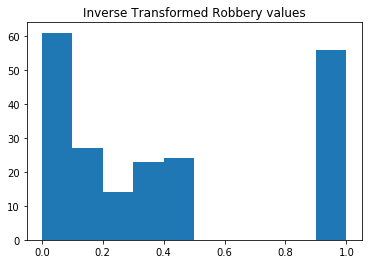

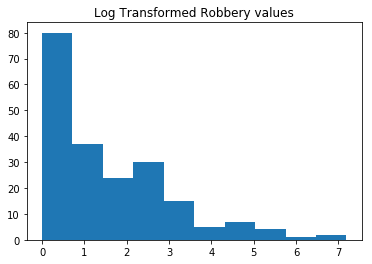

In [48]:
# Look at normality of distribution: robbery

# Sample data.
feature_robbery = df_outliers_removed['robbery']

# Plot the Raw Murder_Manslaughter Values.
plt.hist(feature_robbery)
plt.title('Raw Robbery values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_robbery = [math.sqrt(x) for x in feature_robbery]

# SQRT Murder_Manslaughter feature
plt.hist(sqrt_feature_robbery)
plt.title('Sqrt Transformed Robbery values')
plt.show()

# Create an Absolute Value Feature
df_outliers_removed_abs = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]
feature_robbery_abs = df_outliers_removed_abs['robbery']

abs_feature_robbery = [abs(x) for x in feature_robbery_abs]

# Absolute Value Robbery feature
plt.hist(abs_feature_robbery)
plt.title('Absolute Value Transformed Robbery values')
plt.show()


# Create an Inverse Feature
df_outliers_removed_inverse = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]
feature_robbery_inverse = df_outliers_removed_inverse['robbery']

inverse_feature_robbery = [1/x for x in feature_robbery_inverse]


# Inverse Robbery feature
plt.hist(inverse_feature_robbery)
plt.title('Inverse Transformed Robbery values')
plt.show()


# Create a Log feature using a non-linear transformation.
df_outliers_removed_log = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]


outcome_property_crime_log_2 = df_outliers_removed_log['property_crime']
feature_robbery_log = df_outliers_removed_log['robbery']

log_feature_robbery = [math.log(x) for x in feature_robbery_log]

# Log Robbery feature
plt.hist(log_feature_robbery)
plt.title('Log Transformed Robbery values')
plt.show()

In [49]:
# Get W, P-value
# W: test statistic - closest to 100 is most normal
# P-value: < .05 = NOT normal distribution

print('Shapiro Test - Robbery:')
print('Log: ', stats.shapiro(log_feature_robbery))
print('Inverse: ', stats.shapiro(inverse_feature_robbery))
print('Square Root: ', stats.shapiro(sqrt_feature_robbery))
print('Absolute Value: ', stats.shapiro(abs_feature_robbery))

print()

Shapiro Test - Robbery:
Log:  (0.8874810338020325, 2.928603540230945e-11)
Inverse:  (0.8033197522163391, 2.365435855205384e-15)
Square Root:  (0.5114853382110596, 2.4204414970211014e-29)
Absolute Value:  (0.20274782180786133, 1.0010542090743858e-28)



In [50]:
# Do a log transform to normalize robbery and create new feature called log_robbery

i_robbery = 'robbery'

# Remove any zeros (otherwise we get (-inf)
df_outliers_removed.loc[df_outliers_removed['robbery'] == 0, 'robbery'] = np.nan
 
# Drop NA
df_outliers_removed.dropna(inplace=True)
 
# Log Transform
df_outliers_removed['log_' + i_robbery] = np.log(df_outliers_removed[i_robbery])


### Feature Engineering: Address normality of independent variable, aggravated_assault:

#### Log Transformation best fit and saved as new feature: log_aggravated_assault
#### Distribution remains skewed

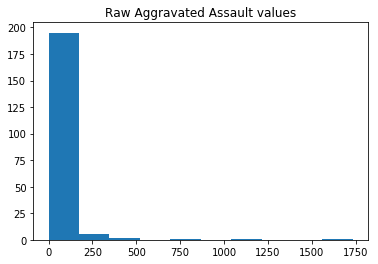

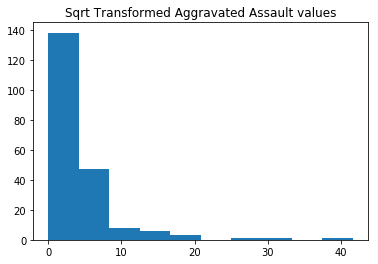

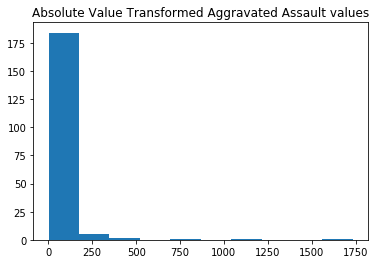

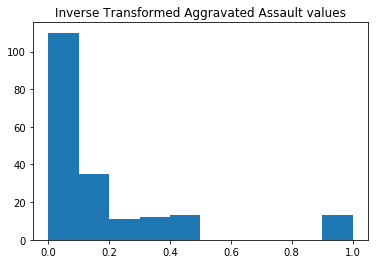

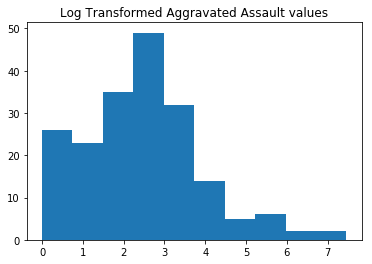

In [51]:
# Look at normality of distribution: relationship of independent variable property crime
# transformed to dependent variable aggravated_assault

# Sample data.
feature_aggravated_assault = df_outliers_removed['aggravated_assault']

# Plot the Raw Murder_Manslaughter Values.
plt.hist(feature_aggravated_assault)
plt.title('Raw Aggravated Assault values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_aggravated_assault = [math.sqrt(x) for x in feature_aggravated_assault]

# SQRT aggravated_assault feature
plt.hist(sqrt_feature_aggravated_assault)
plt.title('Sqrt Transformed Aggravated Assault values')
plt.show()

# Create an Absolute Value Feature
df_outliers_removed_abs_aggravated_assault = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]
feature_aggravated_assault_abs = df_outliers_removed_abs_aggravated_assault['aggravated_assault']

abs_feature_aggravated_assault = [abs(x) for x in feature_aggravated_assault_abs]

# Absolute Value Robbery feature
plt.hist(abs_feature_aggravated_assault)
plt.title('Absolute Value Transformed Aggravated Assault values')
plt.show()


# Create an Inverse Feature
df_outliers_removed_inverse_aggravated_assault = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]
feature_aggravated_assault_inverse = df_outliers_removed_inverse_aggravated_assault['aggravated_assault']

inverse_feature_aggravated_assault = [1/x for x in feature_aggravated_assault_inverse]


# Inverse Robbery feature
plt.hist(inverse_feature_aggravated_assault)
plt.title('Inverse Transformed Aggravated Assault values')
plt.show()


# Create a Log feature using a non-linear transformation.
df_outliers_removed_log = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]


outcome_property_crime_log_3 = df_outliers_removed_log['property_crime']
feature_aggravated_assault_log = df_outliers_removed_log['aggravated_assault']

log_feature_aggravated_assault = [math.log(x) for x in feature_aggravated_assault_log]

# Log Robbery feature
plt.hist(log_feature_aggravated_assault)
plt.title('Log Transformed Aggravated Assault values')
plt.show()

In [52]:
# Get W, P-value
# W: test statistic - closest to 100 is most normal
# P-value: < .05 = NOT normal distribution

print('Shapiro Test - Aggravated Assault:')
print('Log: ', stats.shapiro(log_feature_aggravated_assault))
print('Inverse: ', stats.shapiro(inverse_feature_aggravated_assault))
print('Square Root: ', stats.shapiro(sqrt_feature_aggravated_assault))
print('Absolute Value: ', stats.shapiro(abs_feature_aggravated_assault))

print()

Shapiro Test - Aggravated Assault:
Log:  (0.9681671857833862, 0.00021726002159994096)
Inverse:  (0.6672518253326416, 2.558664797552289e-19)
Square Root:  (0.6127410531044006, 2.86980781561183e-21)
Absolute Value:  (0.2533971667289734, 2.4839901013748035e-27)



In [53]:
# Do a log transform to normalize aggravated_assault and create new feature called log_aggravated_assault

i_aggravated_assault = 'aggravated_assault'

# Remove any zeros (otherwise we get (-inf)
df_outliers_removed.loc[df_outliers_removed['aggravated_assault'] == 0, 'aggravated_assault'] = np.nan
 
# Drop NA
df_outliers_removed.dropna(inplace=True)
 
# Log Transform
df_outliers_removed['log_' + i_aggravated_assault] = np.log(df_outliers_removed[i_aggravated_assault])


### Ordinary Least Squares Linear Regression:

#### Best fit (R-squared = .840) appears with combination of log transformed features: population size, aggravated assault, and robbery

### R-Squared and y-intercept:

#### log_pop_size: .333 and -6490.15
#### log_aggravated_assault: .405 and -816.44
#### log_robbery: .453 and -342.5

#### pop_size + log_aggravated_assault + log_robbery: .840 and -311.93

#### log_pop_size + log_aggravated_assault: .428 and -3246
#### log_pop_size + log_robbery: .462 and -2040.12
#### log_aggravated_assault + log_robbery: .465 and -568.87

#### pop_size: .840 and -287.69
#### aggravated_assault .905 and 259.94
#### robbery: .891 and 325.86

#### pop_size + aggravated_assault + robbery: .956 and -6.01

#### pop_size + aggravated_assault: .956 and -12.88
#### pop_size + robbery: .949 and 11.84
#### aggravated_assault + robbery: .906 and 271.41



In [58]:
lm_4 = smf.ols(formula = "property_crime ~ pop_size + log_robbery + log_aggravated_assault", data = df_outliers_removed).fit()
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     331.8
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.92e-75
Time:                        21:47:49   Log-Likelihood:                -1487.9
No. Observations:                 194   AIC:                             2984.
Df Residuals:                     190   BIC:                             2997.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -311.9318     81.740     -3.816      0.000    -473.167    -150.697
pop_size                   0.0385      0.002     21.064      0.000       0.035       0.042
log_robbery               -3.4962     53.081     -0.066      0.948    -108.201     101.208
log_aggravated_assault    15.6538     52.576      0.298      0.766     -88.054     119.362
==============================================================================
Omnibus:                       43.930   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              602.670
Skew:                          -0.207   Prob(JB):                    1.35e-131
Kurtosis:                      11.625   Cond. No.                     9.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
# Linear regression to prepare for cross validation:

# With original variables
df_regression = df_outliers_removed[['property_crime', 'robbery']]

# Instantiate the model.
regr = linear_model.LinearRegression()

# Fit our model to our data.  Use pd.DataFrame() around the column you're looking to convert
# Otherwise, you get errors related to df vs. pandas series
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

y_regr = df_outliers_removed['property_crime'].values.reshape(-1, 1)
x_regr = df_outliers_removed[['robbery']]

regr.fit(x_regr, y_regr)

# Display the attributes we calculated.

print('Coefficients: \n', regr.coef_)
print()
print('Y Intercept: \n', regr.intercept_)
print()

Coefficients: 
 [[10.05038358]]

Y Intercept: 
 [325.85832273]



### Cross Validation of regression: high instability in R-squared values in 5 random selections of data


In [62]:
# Some variation among cross validation scores, but more consistent than pre-transformed variables
cross_val_scores = cross_val_score(regr, x_regr, y_regr, cv=5)
cross_val_scores


array([0.89250003, 0.15083066, 0.19805286, 0.96144169, 0.80160106])

### Error Residuals Probability Plot shows continued poor fit between expected error and actual error after log transformation of robbery and aggravated_assault in feature engineering

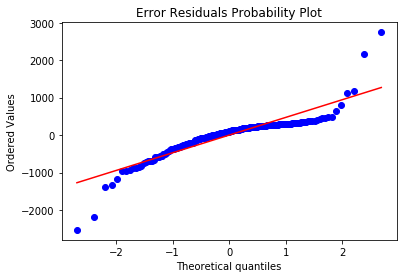

In [63]:
# Probability Plot to view normality (black data should fit to red line of expected error)
stats.probplot(lm_4.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

### Residual Error Plot continues to show poor homoscedasticity after transformed dependent variable and identified best features (pop_size, log_robbery and log_aggravated_assault).

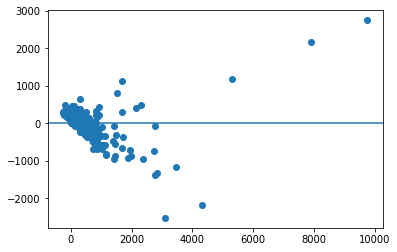

In [64]:
# Residual Error Plot
resid_4 = lm_4.resid
plt.axhline(y=0)
plt.scatter(lm_4.predict(), resid_4);

### Slightly improved statistic for KS test.  Error residual distribution continues to demonstrate poor fit against a normal distribution

In [66]:
# KS test to quantify normality
# reject null hypothesis: residual error is drawn from "same population" as normally distributed population
#(theoretical norm in this case).
# Error is not normally distributed, but much closer to normal than initial KS Test.
# Initial KstestResult(statistic=0.6391752534598999, pvalue=0.0)

print('Kolmogorov-Smirnov test:')
print(stats.kstest(lm_4.resid, 'norm'))

Kolmogorov-Smirnov test:
KstestResult(statistic=0.5979127547650539, pvalue=0.0)


In [69]:
# Check out multicolinearity in correlations between variables
# https://pythonprogramming.net/pandas-statistics-correlation-tables-how-to/
# df_outliers_removed[['log_pop_size', 'log_robbery', 'log_aggravated_assault']].corr()

corr = df_outliers_removed[['pop_size', 'robbery', 'aggravated_assault','log_pop_size', 'log_robbery', 'log_aggravated_assault']].corr().stack()

corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr

pop_size                robbery                  0.827
                        aggravated_assault       0.832
                        log_pop_size             0.777
                        log_robbery              0.730
                        log_aggravated_assault   0.686
robbery                 pop_size                 0.827
                        aggravated_assault       0.987
                        log_pop_size             0.431
                        log_robbery              0.576
                        log_aggravated_assault   0.535
aggravated_assault      pop_size                 0.832
                        robbery                  0.987
                        log_pop_size             0.456
                        log_robbery              0.609
                        log_aggravated_assault   0.592
log_pop_size            pop_size                 0.777
                        robbery                  0.431
                        aggravated_assault       0.456
          

### Review:

#### Linearity: unable to improve linearity through feature enginering

#### Multivariate Normality: feature engineering has some impact on normality of error, but only slightly

#### Homoscedasticity: poor improvement with feature engineering

#### Low multicollinearity: concerns over multicolinearity

### Conclusions:

#### Prior to removing population outlier of NYC from data, pop_size was best predictor of property crime.

#### However, once pop_size outlier of NYC removed, OLS results that included pop_size or log_pop_size resulted in negative y-intercept. Given that the p-value is significant, could've concluded that linear regression model is not a good fit for this data.

#### Removed pop_size and log_pop_size from analysis and conducted PCA.  80% of variance in outcome explained by 4 violent crime variables.  Aggravated assault and robbery appeared to have most linear relationship with property crime.

#### Performed feature engineering to improve normality of independent variables to attempt to get better results. Re-ran OLS and re-checked linearity, multivariate normality, homoscedasticity multicolinearity.  Feature engineering transformations did not address issues present prior to transformations.

#### A linear regression model does not appear to be the best model for this data.


# Logistic Regression

- rape
- property crime

### For purposes of logistic regression assignment, will choose an arbitrary marker to code property crime into categorical variable.

- identify quantiles by population size
- identify mean property crime for each each quantile
- create new variable that assigns:
1 = property crime => mean number of property crimes within the quantile
0 = property crime  < mean number of property crimes within the quantile

https://stackoverflow.com/questions/38356156/dataframe-add-column-whose-values-are-the-quantile-number-rank-of-an-existing-c

In [155]:
#### Testing on rape_2
### Fit the model ###

# Declare predictors.
X_statsmod = df_outliers_removed[['robbery', 'aggravated_assault', 'murder_manslaughter', 'property_crime']].copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.

# 0 = no property crime; 1 = property crime
df_outliers_removed['property_crime_cat'] = np.where(df_outliers_removed['property_crime'] == 0, 0, 1)

df_outliers_removed['rape_cat'] = np.where(df_outliers_removed['rape_2'] == 0, 0, 1)


logit = sm.Logit(df_outliers_removed['rape_cat'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.460428
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               rape_cat   No. Observations:                  194
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Dec 2018   Pseudo R-squ.:                  0.3074
Time:                        09:36:51   Log-Likelihood:                -89.323
converged:                       True   LL-Null:                       -128.96
                                        LLR p-value:                 2.471e-16
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                -0.0601      0.054     -1.113      0.266      -0.166       0.046
a

In [156]:
### Calculate Accuracy ###

# Calculate accuracy of logistic regression model. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code rape occurrence as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df_outliers_removed['rape_cat'], pred_y_statsmod)

print('\n Accuracy by Rape occurrence status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by Rape occurrence status
col_0      0   1
rape_cat        
0         56  18
1         25  95

 Percentage accuracy
0.7783505154639175


### Create quantiles by population size and get mean population size for quantiles

In [157]:
df_outliers_removed['pop_size_quantile'] = pd.qcut(df_outliers_removed['pop_size'], 5, labels=False)

pop_size_mean_by_quantile = df_outliers_removed.groupby(
      ['pop_size_quantile']).agg({'pop_size': ['mean']})

pop_size_mean_by_quantile

,pop_size
,mean
pop_size_quantile,
0,3635.846
1,8024.462
2,14293.079
3,25120.949
4,64667.256


In [158]:
# Set variable to identify quartile range for each city by population size to compare property crime
# only against cities within same quartile

# Look at property crime by quartile
property_crime_mean_by_quantile = df_outliers_removed.groupby(
      ['pop_size_quantile']).agg({'property_crime': ['median', 'mean','std','count']})

print(property_crime_mean_by_quantile)
print()
print('There is a lot of variance even within population size quartiles.')
print('The standard deviation for quartile 4 is much greater than the mean.')

                  property_crime                        
                          median     mean      std count
pop_size_quantile                                       
0                            101  115.744   71.990    39
1                            155  185.769  113.953    39
2                            314  334.395  197.152    38
3                            471  533.051  306.677    39
4                           1167 1895.179 2489.240    39

There is a lot of variance even within population size quartiles.
The standard deviation for quartile 4 is much greater than the mean.


Explosion in median and mean from quartile 3 to quartile 4, as well as being only quartile in which std is greater than the mean may make it a quartile that needs to be treated differently than other quartiles.

For the purposes of this assignment, will create another arbitrary category to separate quartile 4 and look at it differently than cities in quartile 0-3.

Problem with this method means that n for quartiles 0-3 makes up about 75% of observations and quartile 4 makes up about 25% of observations.

In [159]:
# create column that identifies quartile 0-3 separately from quartile 4
df_outliers_removed['quantile_0-3'] = np.where(df_outliers_removed['pop_size_quantile'] < 4, 1, 0)


In [160]:
# Set variables that calculate quartile means
quantile_0_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 0),
                                                         'property_crime'].mean()

quantile_1_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 1),
                                                         'property_crime'].mean()

quantile_2_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 2),
                                                         'property_crime'].mean()

quantile_3_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 3),
                                                         'property_crime'].mean()

quantile_4_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 4),
                                                         'property_crime'].mean()


In [161]:
# Set variable to code all property crimes above the mean for each quartile range as 1
property_crime_cat_1 = (

# quartile 0 above mean

((df_outliers_removed['pop_size_quantile'] == 0) & 
                        (df_outliers_removed['property_crime'] > quantile_0_property_crime_mean)) |

# quartile 1 above mean
((df_outliers_removed['pop_size_quantile'] == 1) & 
                        (df_outliers_removed['property_crime'] > quantile_1_property_crime_mean)) |

# quartile 2 above mean
((df_outliers_removed['pop_size_quantile'] == 2) & 
                        (df_outliers_removed['property_crime'] > quantile_2_property_crime_mean)) |

# quartile 3 above mean
((df_outliers_removed['pop_size_quantile'] == 3) & 
                        (df_outliers_removed['property_crime'] > quantile_3_property_crime_mean)) |

# quartile 4 above mean

((df_outliers_removed['pop_size_quantile'] == 4) & 
                        (df_outliers_removed['property_crime'] > quantile_4_property_crime_mean))
)

# Code 1 for any property crime above mean for the quartile in which that city exists
df_outliers_removed['property_crime_above_mean'] = np.where(
    property_crime_cat_1, 1, 0)


In [162]:
# Prepare for Logistic Regression:

# set variables for quantiles 0-3
quantiles_0_3 = df_outliers_removed.loc[df_outliers_removed['quantile_0-3'] == 1]
#print(quantiles_0_3.count())

# set variable for quantile 4:
quantile_4 = df_outliers_removed.loc[df_outliers_removed['quantile_0-3'] == 0]


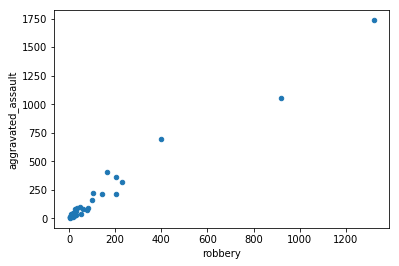

In [163]:

### Fit the Logistic Regression model ###

# Declare predictors.
X_statsmod_all = df_outliers_removed[['robbery', 'aggravated_assault', 'murder_manslaughter']].copy()

X_statsmod_quantiles_0_3 = quantiles_0_3[['robbery', 'aggravated_assault', 'murder_manslaughter']].copy()

X_statsmod_quantile_4 = quantile_4[['robbery', 'aggravated_assault', 'murder_manslaughter']].copy()
# x_statsmod = df made up of 3 columns

#print(type(X_statsmod_quantiles_0_3))
# add another column - it's a series, also called a scalar, and it's 1 dimensional: 
# left side (X_statsmod['intercept']) dimension is m x 1 (where m is the number of rows)
# right side is scalar
# m = matrix = rows
# n = columns

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept. y intercept tells you how high you are.  given 1 independent variable x
# we still need to estimate two coef - the slope of the line and the y intercept.  The model
# assumes it's 0. It's a place holder for the coef that it's going to be estimating. If the y intercept assumes 0
# it biases the result. y = 1 prevents it.
# y = b * m + 1 + x
# the 1 is the constant that doesn't change per row, x is the variable that does show
# y_intercept column is a variable that doesn't change - it's a placeholder for the intercept - it's what the intercept
# is going to be multiplied by - it's a constant.
# 

X_statsmod_all['y_intercept'] = 1 

X_statsmod_quantiles_0_3['y_intercept'] = 1 

X_statsmod_quantile_4['y_intercept'] = 1 

# Declare and fit the model.
# shape is a reference, not a call - a variable. It's an object

# Reason about objects by type, size, and shape.
#type(X_statsmod.shape)

# Reason about function by calls

# Plot robbery and aggravated assault just to explore
X_statsmod_quantile_4.plot.scatter('robbery','aggravated_assault');

## Logit: logistic regression using 3 versions: all quartiles, quartiles 0-3, and quartile 4 just to see difference

- All quantiles: robbery and aggravated assault are signficant
- Quantiles 0 - 3: aggravated assault is significant
- Quantile 4: aggravated assault is significant

Will cut murder_manslaughter feature since it does not appear significant.  Will use all quantiles for purpose of assignment.

In [164]:
### Fit the Logistic Regression model ###

# Instantiate and Fit the StatsModel Logistic Regression for all quantiles.

logit_all = sm.Logit(df_outliers_removed['property_crime_above_mean'], X_statsmod_all)
logit_result_all = logit_all.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(logit_result_all.summary())


Optimization terminated successfully.
         Current function value: 0.605651
         Iterations 7
                               Logit Regression Results                              
Dep. Variable:     property_crime_above_mean   No. Observations:                  194
Model:                                 Logit   Df Residuals:                      190
Method:                                  MLE   Df Model:                            3
Date:                       Tue, 18 Dec 2018   Pseudo R-squ.:                  0.1012
Time:                               09:37:03   Log-Likelihood:                -117.50
converged:                              True   LL-Null:                       -130.72
                                               LLR p-value:                 7.651e-06
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                -0.0485    

$$logit(quartilesAllHasPropertyCrime) = -0.8961 + -0.0485 * robbery + 0.0443 * aggravatedassault + 0.0175 * murdermanslaughter$$

In [165]:
### Fit the Logistic Regression model ###

# Instantiate and Fit the StatsModel Logistic Regression for quantiles 0-3.

logit_0_3 = sm.Logit(quantiles_0_3['property_crime_above_mean'], X_statsmod_quantiles_0_3)
logit_result_0_3 = logit_0_3.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(logit_result_0_3.summary())

Optimization terminated successfully.
         Current function value: 0.548677
         Iterations 8
                               Logit Regression Results                              
Dep. Variable:     property_crime_above_mean   No. Observations:                  155
Model:                                 Logit   Df Residuals:                      151
Method:                                  MLE   Df Model:                            3
Date:                       Tue, 18 Dec 2018   Pseudo R-squ.:                  0.1956
Time:                               09:37:05   Log-Likelihood:                -85.045
converged:                              True   LL-Null:                       -105.73
                                               LLR p-value:                 5.484e-09
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                 0.0721    

$$logit(quartiles0-3HasPropertyCrime) = -1.6082 + 0.0721 * robbery + 0.0784 * aggravatedassault + 0.1267 * murdermanslaughter$$

In [166]:
### Fit the Logistic Regression model ###

# Instantiate and Fit the StatsModel Logistic Regression for quantiles 0-3.

logit_4 = sm.Logit(quantile_4['property_crime_above_mean'], X_statsmod_quantile_4)
logit_result_4 = logit_4.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(logit_result_4.summary())

Optimization terminated successfully.
         Current function value: 0.344450
         Iterations 8
                               Logit Regression Results                              
Dep. Variable:     property_crime_above_mean   No. Observations:                   39
Model:                                 Logit   Df Residuals:                       35
Method:                                  MLE   Df Model:                            3
Date:                       Tue, 18 Dec 2018   Pseudo R-squ.:                  0.4420
Time:                               09:37:07   Log-Likelihood:                -13.434
converged:                              True   LL-Null:                       -24.072
                                               LLR p-value:                 9.218e-05
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                -0.0363    

$$logit(quartile4HasPropertyCrime) = -2.6312 + -0.0363 * robbery + 0.0404 * aggravatedassault + 0.0832 * murdermanslaughter$$

## Understanding What Logistic Regression Does:

### Vector linear algebra

#### Logit takes two vectors of same length, multiplies them together, and then sums them up.

- -0.0485,0.0443,0.0175,-0.8961 are coefficients from "all" logit version.  They are the coef that were calculated for robbery, aggravated assault, murder_manslaughter, and y-intercept.
- multiply these coefficients with the observation numbers in the row for robbery, aggravated assault, murder, manslaughter, y intercept.
- sum them together

In [167]:
# see one row at a time (1 row x 4 columns)

# Get and print row 2 as an example
print(X_statsmod_all.iloc[2])

# Calculate logit(property_crime) by multiplying each coef of robbery, aggravated assault,
# murder_manslaughter, and y-intercept with each of the observations for row 2, and sum them together.
y = X_statsmod_all.iloc[2].dot([-0.0485,0.0443,0.0175,-0.8961])
print()

# Print summed together value of coefficients multiplied with row 2 observations for this city
print('Calculated logit(property_crime) for row 2: ' , y)
print()
print('The inverse of logit(property_crime) gives probability of property crime for this row.')


robbery               31.000
aggravated_assault    68.000
murder_manslaughter    1.000
y_intercept            1.000
Name: 12, dtype: float64

Calculated logit(property_crime) for row 2:  0.6303

The inverse of logit(property_crime) gives probability of property crime for this row.


see: https://www.youtube.com/watch?v=vN5cNN2-HWE (5:09)

In linear regression, both variables are continuous, but in logistic regression, the y variable is categorical: property crime above the mean for that quantile ~ or ~ property crime not above the mean for that quantile.

That's why you see a line in linear regression and a sigmoid (s) curve in logistic regression.

To solve this problem, the y-axis is transformed from the "probability of property crime above the mean" to the log(odds of property crime above the mean)

Now, like a linear regression, the logistic regression can go from -infinity to +infinity

see: https://www.youtube.com/watch?v=vN5cNN2-HWE (5:25)

## Transform y axis from "probability of property crime above mean" scale to log(property crime above mean) scale (sigmoid curve gets transformed into a line):

$$logit(p / (1-p))$$

$$log(probability of property crime above mean / (1 - probability of property crime above mean))$$

1. Plug p = 0.5 into the logit formula

The mid-point on the old y-axis ("probability of property crime above the mean") is 0.5.

When you plug 0.5 into the logit formula, you get "0" - the center of the new y-axis:

$$logit(0.5 / (1-0.5))$$
$$log(1) = 0$$

If you move one up on the old y-axis to 0.731 and plug it into the logit formula, you get:

$$log(2.717)$$

$$log(2.717) = 1$$

1 is the next unit up on the new y-axis

2. the data points that = 1 end up representing positive infinity because of the way the math works out when you plug 1 into the logit function.  The log(0) is defined as negative infinity:

$$logit(1 / (1-1))$$

$$log(1 / (0))$$

$$something positive - negative infinity = positive infinity$$

As a result, the old y-axis on the sigmoid curve from 0.5 - 1 is stretched out from 0 to positive infinity on new y-axis.

3. the data points that = 0 end up representing negative infinity because of the way the math works out when you plug 1 into the logit function

As a result, the old y-axis on the sigmoid curve from 0.5 - 0 is stretched out from 0 to negative infinity on new y-axis.

#### Ultimately, transformation results in log(property crime above the mean) on the new y-axis - a sigmoid curve to a straight line (7:56)


## Understanding the new graph (continuous variables):

(8:21) Now, the coef are presented in terms of the log(odds) graph.

1. Just like with linear regression, the y-axis has a best fitting:
y-intercept (-1.8961)
slope (robbery slope = 0.4005, aggravatedassault slope = 0.2703, murdermanslaughter slope = 1.2399)

$$logit(HasPropertyCrime) = -1.8961 + 0.4005 * robbery + 0.2703 * aggravatedassault + 1.2399 * murdermanslaughter$$

2. Coef:


- Coef are same as for linear regression, except they are expressed in terms of the log(odds)

- Coef for y means that when variables are at 0 (robbery, aggravated_assault, and murder_manslaughter), the log(odds of property crime) is -1.8961

- Coef for robbery means that for every one unit increase in robbery committed, the log(odds of property crime) increases by 0.4005

- Coef for aggravated_assault means that for every one unit increase in aggravated_assault committed, the log(odds of property crime) increases by 0.2703

- Coef for murder_manslaughter means that for every one unit increase in murder_manslaughter committed, the log(odds of property crime) increases by 1.2399 (but note that results are not signficant)



3. (10:25) Wald's Test - if it's less than 2 standard deviations away from 0, z value is not significant:

Robbery z value = estimated intercept / standard error
Robbery z value =  0.4005 / 0.179

Robbery z value = number of standard deviations the estimated y-intercept is away from 0 on a standard normal curve
Robbery z value = 2.236

Robbery z value is signficant since it is greater than 2 std away from 0 on a standard normal curve
(10:36) Significance is confirmed by p-value indicating significance (p-value = 0.025).

## Understanding the new graph (discrete variables):

What to do if you want to predict presence of any property crime based on whether or not there are robberies (if you changed robbery to a discrete variable: 0 = no robberies committed; 1 = robberies committed)

This type of logistic regression is similar to using a T test in linear models
(11:45 - 14:16) Review of T-test

1. Calculate mean of dependent variable (property_crime) in presence discrete variable (robbery):

in this case, we don't care about property crime below the mean for that quantile


- mean of property crime numbers above the mean of property crime for that quantile where there is no robbery

- mean of property crime numbers above the mean of property crime for that quantile where there is robbery


So you end up with:

- mean number of property crimes for cities with property crime above the mean for its quantile with no robberies
- mean number of property crimes for cities with property crime above the mean for its quantile with robberies


2. Use the means to calculate the coefficients in the equation:
$$B_1 = coef for property crime with NOrobbery$$

$$B_2 = coef for property crime with Robbery$$

$$propertycrime = meanpropertycrimeNOrobberies * B_1 + (meanpropertycrimeRobberies - meanpropertycrimeNOrobberies) * B_2$$


3. Pair equation with design matrix to predict property crime given whether there are robberies or not.

the matrix has two columns.

Column 1 (like the y_intercept column above):
$$B_1 = coef for property crime with NOrobbery$$
- just like above (column='y_intercept' in logit model), the first column in the matrix is 1 for each row
- y_intercept column is a variable that doesn't change - it's a placeholder for the intercept - it's what the intercept is going to be multiplied by - it's a constant.

Column 2:
$$B_2 = coef for property crime with Robbery$$
- the variable that does change according to whether the independent variable (robbery) is 0 or 1 based on No Robbery, or Robbery.


4. Do the math by plugging in coef based on matrix to predict property crime based on presence of robberies (0 or 1).


- If first row of matrix corresponds to robberies = 0, then:

$$B_1 = coef for property crime with NOrobbery = 1$$

$$B_2 = coef for property crime with Robbery = 0$$

$$propertycrime = meanpropertycrimeNOrobberies * 1 + (meanpropertycrimeRobberies - meanpropertycrimeNOrobberies) * 0$$


- If first row of matrix corresponds to robberies = 1, then:

$$B_1 = coef for property crime with NOrobbery = 1$$

$$B_2 = coef for property crime with Robbery = 1$$

$$propertycrime = meanpropertycrimeNOrobberies * 1 + (meanpropertycrimeRobberies - meanpropertycrimeNOrobberies) * 1$$


5. When we do a T-test this way, we are basically testing to see if this coef (meanpropertycrimeRobberies - meanpropertycrimeNOrobberies) is = 0.

### How this t-test stuff for linear regression applies to logistic regression.

1. Transform y-axis from probability of property crime existing to log(odds of property crime)
2. Fit two lines to the data

For the first line:
- log(odds property crime with cities with No Robberies) = take the No Robberies data and calculate the log(odds of property crime) for cities with No Robberies.

For the second line:
- log(odds property crime with cities with Robberies) = take the Robberies data and calculate the log(odds of property crime) for cities with No Robberies.

3. Plug in data for equation:

$$propertycrime = log(odds property crime with cities with No Robberies) * B_1 + (log(odds property crime with cities with Robberies) - log(odds property crime with cities with No Robberies)) * B_2$$

Since subtracting one log from another, this term is a log(odds ratio)

log(odds ratio) = how much having the presence of robberies increases (or decreases) the odds of a city having property crimes.

next video to watch:
https://www.youtube.com/watch?v=yIYKR4sgzI8

In [168]:
# logit(p / (1-p)) - probability something happened divided by probability it didn't happen = odds
# when you take the log of odds = log odds.

# turns the reciprocal odds is the negative - turn ratios whose inverses are very small - 3 becomes 1/3.
# log odds allows you to flip the sign.

In [169]:
# reference: http://blog.yhat.com/posts/logistic-regression-and-python.html

# natural log (exponentiation)
print('Exponential of 1 with np.exp(1): ', np.exp(1))
print()

#Undo the log
print('Undo the exponential of 1 with np.log(2.718281828459045): ', np.log(2.718281828459045))
print()

#get the log and then undo the log
print('Get the exponential and then undo it with np.exp(np.log(1))): ', np.exp(np.log(1)))
print()

print('-------------')

print('Aggravated Assault coef: 0.0404')
# turn aggravated assault coef into odds ratio - 1 unit of robbery increase, creates this much change in property_crime
#likelihood
print('Odds Ratio with aggravated_assault coef -> np.exp(0.0404): ', np.exp(0.0404))
print()

# convert aggravated_assault coef into probability:
p = np.exp(0.0404)/(1 + np.exp(0.0404))
print('Probability of property crime with aggravated assault -> np.exp(0.0404)/(1 + np.exp(0.0404): ', p)


Exponential of 1 with np.exp(1):  2.718281828459045

Undo the exponential of 1 with np.log(2.718281828459045):  1.0

Get the exponential and then undo it with np.exp(np.log(1))):  1.0

-------------
Aggravated Assault coef: 0.0404
Odds Ratio with aggravated_assault coef -> np.exp(0.0404):  1.0412271817780303

Probability of property crime with aggravated assault -> np.exp(0.0404)/(1 + np.exp(0.0404):  0.5100986264895119


Interpretation of regression models:
https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

## Doing Logit again to keep flow together and remove murder_manslaughter since it doesn't perform well and results are not signficant

In [170]:
### Fit the Logistic Regression model ###

# Declare predictors.
X_statsmod2 = df_outliers_removed[['robbery', 'aggravated_assault']].copy()
X_statsmod2['y_intercept'] = 1 

logit2 = sm.Logit(df_outliers_removed['property_crime_above_mean'], X_statsmod2)
result2 = logit2.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.605672
         Iterations 7
                               Logit Regression Results                              
Dep. Variable:     property_crime_above_mean   No. Observations:                  194
Model:                                 Logit   Df Residuals:                      191
Method:                                  MLE   Df Model:                            2
Date:                       Tue, 18 Dec 2018   Pseudo R-squ.:                  0.1012
Time:                               09:37:15   Log-Likelihood:                -117.50
converged:                              True   LL-Null:                       -130.72
                                               LLR p-value:                 1.806e-06
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
robbery               -0.0476      0

- Coef for y means that when variables are at 0 (robbery, aggravated_assault), the log(odds of property crime) is -0.8972

- Coef for robbery means that for every one unit increase in robbery committed, the log(odds of property crime) decreases by 0.0476

- Coef for aggravated_assault means that for every one unit increase in aggravated_assault committed, the log(odds of property crime) increases by 0.0442

## Box Plots To Explore Importance of Predictors

- There is a lot of variance in robbery and aggravated assault when all quartiles are included, so hard to see impact of predictors in box plots.

- When predictors are explored by groups quantiles, impact of predictors is clearer.

- Looks like predictors are correlated with each other.

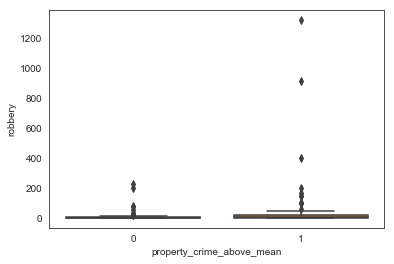

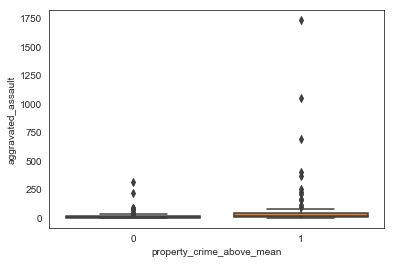

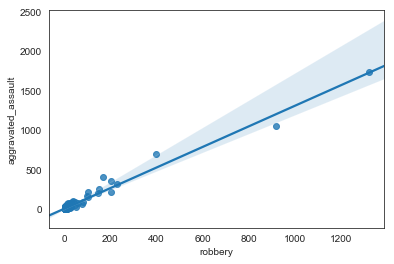

In [171]:
# Prettier plots are better.
sns.set_style("white")

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x="property_crime_above_mean", y="robbery", data=df_outliers_removed)
plt.show()
sns.boxplot(x="property_crime_above_mean", y="aggravated_assault", data=df_outliers_removed)
plt.show()

# Relationship between predictors.
sns.regplot(x='robbery', y='aggravated_assault', data=df_outliers_removed)
plt.show()

#### Box Plots: Quantiles 0 - 3

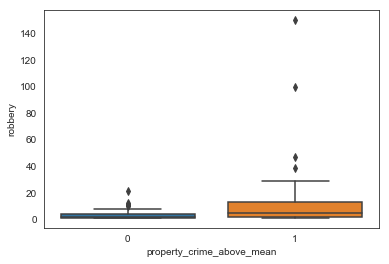

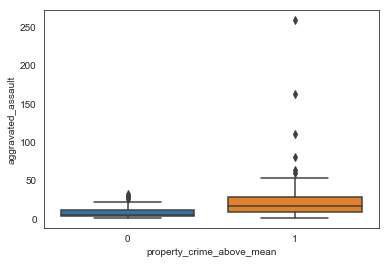

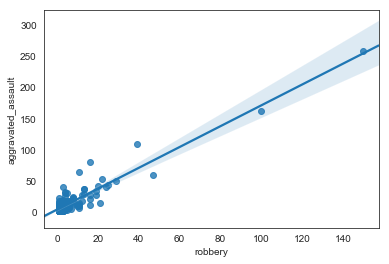

In [172]:

# Prettier plots are better.
sns.set_style("white")

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x="property_crime_above_mean", y="robbery", data=quantiles_0_3)
plt.show()
sns.boxplot(x="property_crime_above_mean", y="aggravated_assault", data=quantiles_0_3)
plt.show()

# Relationship between predictors.
sns.regplot(x='robbery', y='aggravated_assault', data=quantiles_0_3)
plt.show()

#### Box Plots: Quantile 4

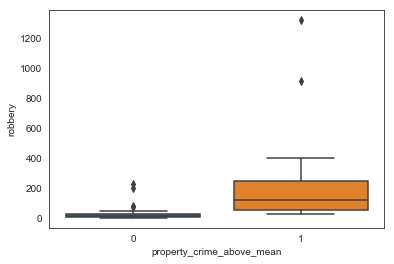

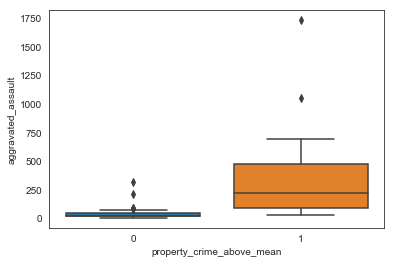

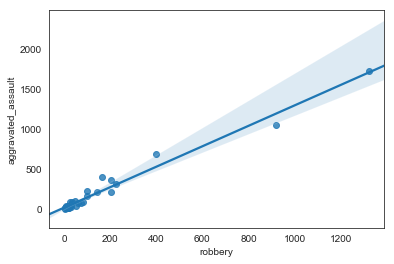

In [173]:
# Prettier plots are better.
sns.set_style("white")

# Bivariate relationships of predictors to admissions outcome.
sns.boxplot(x="property_crime_above_mean", y="robbery", data=quantile_4)
plt.show()
sns.boxplot(x="property_crime_above_mean", y="aggravated_assault", data=quantile_4)
plt.show()

# Relationship between predictors.
sns.regplot(x='robbery', y='aggravated_assault', data=quantile_4)
plt.show()

### Calculate Accuracy of Logit Model
Accuracy: 66.5%

In [174]:
# Calculate accuracy. First, get probability that each row will result in presence of property crime above mean.
pred_statsmod2 = result2.predict(X_statsmod2)

# Code property_crime_above_mean as 1 if probability is greater than .5.
pred_y_statsmod2 = np.where(pred_statsmod2 < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df_outliers_removed['property_crime_above_mean'], pred_y_statsmod2)

print('\n Accuracy by property crime above the mean status:')
print(table)

print('\n Percentage accuracy:')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))



 Accuracy by property crime above the mean status:
col_0                        0   1
property_crime_above_mean         
0                          107   9
1                           56  22

 Percentage accuracy:
0.6649484536082474


## Set up linear regression with continuous variables so Ridge and Lasso Regressions can be applied

In [175]:

# take out string related columns to avoid errors and remove all other added columns as well
df_outliers_removed_linear_no_city = df_outliers_removed.drop(columns=['city', 'violent_crime', 'rape_cat',
                                                                       'murder_manslaughter_cat', 'robbery_cat',
                                                                       'log_pop_size', 'outlier','log_robbery', 
                                                                       'log_aggravated_assault',  
                                                                       'pop_size_quantile',  'murder_manslaughter',
                                                                       'property_crime_above_mean', 'arson_3',
                                                                       'burglary', 'larceny_theft','mv_theft'])

names = df_outliers_removed_linear_no_city.columns
#print(names)

# normalize distributions and turn into dataframe
df_outliers_removed_linear_regression = pd.DataFrame(preprocessing.scale(df_outliers_removed_linear_no_city), columns=names)

# Define the training and test sizes.
trainsize = int(df_outliers_removed_linear_regression.shape[0] / 2)

# trainsize = 97
#print(trainsize)

df_outliers_removed_linear_regression_test = df_outliers_removed_linear_regression.iloc[trainsize:, :].copy()
df_outliers_removed_linear_regression_train = df_outliers_removed_linear_regression.iloc[:trainsize, :].copy()

# Set up the linear regression model to predict defaults using all other variables as features in training set.
linear_regr_simple = linear_model.LinearRegression()
Y_train_linear_regression = df_outliers_removed_linear_regression_train['property_crime'].values.reshape(-1, 1)
X_train_linear_regression = df_outliers_removed_linear_regression_train.loc[:, ~(df_outliers_removed_linear_regression_train.columns).isin(['property_crime'])]
linear_regr_simple.fit(X_train_linear_regression, Y_train_linear_regression)

#print('y train: ', Y_train_linear_regression)
#print('x train: ')
#print(X_train_linear_regression)

print('\nR-squared simple model - original features (Train):')
print(linear_regr_simple.score(X_train_linear_regression, Y_train_linear_regression))
print()

#Store the parameter estimates.
origparams = np.append(linear_regr_simple.coef_, linear_regr_simple.intercept_)
print('Coefficients for simple model: ', origparams)

# If I want to compare ridge regression against data with other potential features: 
# capture potential quadratic and cubic relationships #between the features

# explore square root, quadratic, or cubic relationships on train
df_outliers_removed_linear_regression_train['property_crime_sqrt'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** .5
df_outliers_removed_linear_regression_train['property_crime_2'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** 2
df_outliers_removed_linear_regression_train['property_crime_3'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** 3

# Re-run the model with the new features.
lin_regr_complex = linear_model.LinearRegression()
X_train_linear_regression_complex = df_outliers_removed_linear_regression_train.loc[:, ~(df_outliers_removed_linear_regression_train.columns).isin(['property_crime'])]

lin_regr_complex.fit(X_train_linear_regression_complex, Y_train_linear_regression)

print('\nR-squared complex model - added features (Train):')
print(lin_regr_complex.score(X_train_linear_regression_complex, Y_train_linear_regression))
print()
# Store the new parameter estimates for the same features.
newparams = np.append(
    lin_regr_complex.coef_[0,0:(len(origparams)-1)],
    lin_regr_complex.intercept_)

print('Coefficients for complex model: ', newparams)

print('\nParameter Estimates for same predictors for the original features model (simple)'
      ' and added features model (complex):')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)



R-squared simple model - original features (Train):
0.9752424585167813

Coefficients for simple model:  [ 0.41091792  0.32767637 -0.11153433  0.3651622  -0.00815893  0.
  0.00318344]

R-squared complex model - added features (Train):
0.9999999999999988

Coefficients for complex model:  [ 2.96586404e-08  4.69036980e-08  2.14381453e-07 -2.53071273e-07
  7.50268761e-09 -2.84153903e-13 -1.34158636e+02]

Parameter Estimates for same predictors for the original features model (simple) and added features model (complex):
[[0.411 0.000]
 [0.328 0.000]
 [-0.112 0.000]
 [0.365 -0.000]
 [-0.008 0.000]
 [0.000 -0.000]
 [0.003 -134.159]]


When you look at the coefficients of the small model and complex model, you do not want to see a huge difference. A huge difference in coefficients may be indicative of over-fitting.

- R-squared = inear relationship between the actual and predicted continuous values
- Accuracy = only for classification

There is a small gain in R-squared (linear relationship between the actual and predicted continuous values):

- simple model = 0.9752424585167813
- complex model = 0.9999999999999988


Since there is a large difference in the last parameter - [-0.002 -134.160] the R-squared gains appear likely to be due to overfit.

Will test to see if this is the case by trying a ridge model on test data and compare performance results with the linear regression (any non ridge model). If the ridge model performs worse, then it's probably over-fitting

--

You can compare Ridge model with any other model you choose. So for example you create a linear regression where we want to predict property_crime_above_mean onto robbery, aggravated_assault, and murder_manslaughter.

Then you use these same variables in a ridge regression. You can then compare the test results.

## Apply the Simpler Model (fewer features) and Complex Model (more features) to Test set to look at possible overfit

The more complex model (more features) performs better than the simple model - moreso than on train set.

In [178]:

# Test the simpler model with smaller coefficients. (.values turns df into array)
Y_test_simple = df_outliers_removed_linear_regression_test['property_crime'].values.reshape(-1, 1)
X_test_simple = df_outliers_removed_linear_regression_test.loc[:, ~(df_outliers_removed_linear_regression_test.columns).isin(['property_crime'])]

print('\nR-squared simple model (Test):')
print(linear_regr_simple.score(X_test_simple, Y_test_simple))

# Test the more complex model with larger coefficients.
df_outliers_removed_linear_regression_test['property_crime_sqrt'] = (df_outliers_removed_linear_regression_test['property_crime'] + 100) ** .5
df_outliers_removed_linear_regression_test['property_crime_1'] = (df_outliers_removed_linear_regression_test['property_crime'] + 100) ** 2
df_outliers_removed_linear_regression_test['property_crime_2'] = (df_outliers_removed_linear_regression_test['property_crime'] + 100) ** 3

# Re-run the model with the new features.
X_test_complex = df_outliers_removed_linear_regression_test.loc[:, ~(df_outliers_removed_linear_regression_test.columns).isin(['property_crime'])]
print('\nR-squared complex model (Test):')
print(lin_regr_complex.score(X_test_complex, Y_test_simple))



R-squared simple model (Test):
0.9457040405056266

R-squared complex model (Test):
0.9999999999927163


## Ridge Regression

Will apply the ridge model to the original train set

In [180]:
# Instantiate and fit the model
ridgeregr_simple = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr_simple.fit(X_train_linear_regression, Y_train_linear_regression)
print('Training Data:')
print('\nRidge Regression Simple (fewer features) Fit: ',ridgeregr_simple.score(X_train_linear_regression, Y_train_linear_regression))

origparams = ridgeregr_simple.coef_[0]

# "Complex" Ridge Regression (added features of square root, quadratic, cubic)
ridgeregr_complex = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregr_complex.fit(X_train_linear_regression_complex, Y_train_linear_regression)

print('\nRidge Regression Complex (more features) Fit: ', ridgeregr_complex.score(X_train_linear_regression_complex, Y_train_linear_regression))
newparams = ridgeregr_complex.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      ' and complex model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


Training Data:

Ridge Regression Simple (fewer features) Fit:  0.9720392155832049

Ridge Regression Complex (more features) Fit:  0.9991684795156465

Parameter Estimates for the same predictors for the small model and complex model:
[[0.318 0.015]
 [0.263 -0.014]
 [0.164 -0.040]
 [0.195 -0.033]
 [-0.050 -0.017]
 [0.000 0.000]]


The difference in magnitude for parameters in the training set is much smaller – no parameter explosion here. Let's check the implications for the fit of the models on the test data.

In [182]:
print('Accuracy Score (Test Data):')
print('Simple (fewer features) Ridge: ', ridgeregr_simple.score(X_test_simple, Y_test_simple))
print('Complex (more features) Ridge: ', ridgeregr_complex.score(X_test_complex, Y_test_simple))


Accuracy Score (Test Data):
Simple (fewer features) Ridge:  0.9458158762713565
Complex (more features) Ridge:  0.9971434882861118


## Ridge Regression: Choose an optimal regularization parameter: λ

- graph for visual purposes
- calculate optimal alpha for regularization parameter λ

The graph shows that with lambda as the X axis and R^2 as the Y axis the training accuracy decreases as lambda increases.

So when you increase lambda, you decrease training set accuracy - with the idea that you actually increase test set accuracy, because you are reducing overfitting.

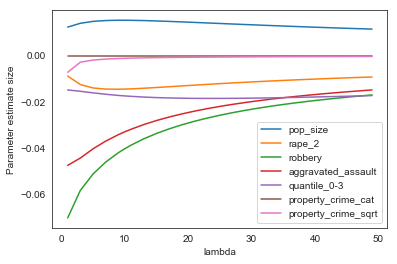

In [185]:
# Ridge Regression - graphing alpha increase and its impact on accuracy

# Store estimates.
estimates = np.append(ridgeregr_complex.coef_, [10])
#print(X_train_linear_regression_complex.shape)
#print(estimates.shape)

#estimates

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregr_complex_lambda = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregr_complex_lambda.fit(X_train_linear_regression_complex, Y_train_linear_regression)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregr_complex_lambda.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train_linear_regression_complex.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# checking that df includes needed columns
#print(estimates_df)

# index columns to exclude lambda column value from variables to plot
varstoplot = list(estimates_df.columns[:7,])

# Checking type and making sure lambda column not included in varstoplot
#type(varstoplot)
#varstoplot

# Leave out variables with high values and throw off plot scale
#varstoplot.remove('property_crime_2')
#varstoplot.remove('property_crime_3')
#varstoplot.remove('property_crime_sqrt')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()



### Calculate and find best alpha for lambda using gridsearchcv

Start with lower alphas and explore with bigger ones - you're limited by the parameters you initially input, so if you don't try different ones, you may miss best alpha because it isn't one of the original parameters. 

In [187]:
# Simple version to find the best alpha:
params_simple = {'alpha':[0.01, 0.02, 0.04, 0.06, 0.08, .1, .2, .4, .6, .8, 1, 10], 'fit_intercept':[True, False]}
grid = GridSearchCV(ridgeregr_complex, params_simple, cv=5)
grid.fit(X_train_linear_regression_complex, Y_train_linear_regression)
print(grid.best_params_)
print(grid.best_score_)


{'alpha': 0.1, 'fit_intercept': True}
0.9999999554445769


In [196]:
# Less simple version to find the best alpha:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# Set the parameters by cross-validation

# add bold to print statement
# https://stackoverflow.com/questions/287871/print-in-terminal-with-colors
class boldtype:
    BOLD = '\033[1m'
    ENDC = '\033[0m'

tuned_parameters = {'alpha':[0.01, 0.02, 0.04, 0.06, 0.08, .1, .2, .4, .6, .8, 1, 10], 'fit_intercept':[True, False]}

cross_val_lambda_scores = ['precision', 'recall']

for score in cross_val_lambda_scores:
    print()
    print(boldtype.BOLD + "Tuning hyper-parameters for %s :" % score  + boldtype.ENDC)
    print()

    clf = GridSearchCV(ridgeregr_complex, tuned_parameters, cv=5, max_iter=5
    clf.fit(X_train_linear_regression_complex, Y_train_linear_regression)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #print('Mean Results: ', means)
    #print()
    #print('Standard Deviation Results: ', stds)
    #print()
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
#     For a detailed classification report (only categorical variables - no continuous variables)
#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = Y_test_simple, clf.predict(X_test_complex)
#     print(classification_report(y_true, y_pred))
#     print()
    


Tuning hyper-parameters for precision :

Best parameters set found on development set:

{'alpha': 0.1, 'fit_intercept': True}

Grid scores on development set:

1.000 (+/-0.000) for {'alpha': 0.01, 'fit_intercept': True}
0.985 (+/-0.025) for {'alpha': 0.01, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.02, 'fit_intercept': True}
0.984 (+/-0.025) for {'alpha': 0.02, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.04, 'fit_intercept': True}
0.984 (+/-0.025) for {'alpha': 0.04, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.06, 'fit_intercept': True}
0.984 (+/-0.025) for {'alpha': 0.06, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.08, 'fit_intercept': True}
0.984 (+/-0.025) for {'alpha': 0.08, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.1, 'fit_intercept': True}
0.984 (+/-0.024) for {'alpha': 0.1, 'fit_intercept': False}
1.000 (+/-0.000) for {'alpha': 0.2, 'fit_intercept': True}
0.985 (+/-0.024) for {'alpha': 0.2, 'fit_intercept': Fal

## Lasso Regression

In [197]:
## Lasso Regression

# Small number of parameters (features).
lass_simple = linear_model.Lasso(alpha=.35)
lass_simple.fit(X_train_linear_regression, Y_train_linear_regression)
print('R² for Lasso Regression on the simple model - few features:')
print(lass_simple.score(X_train_linear_regression, Y_train_linear_regression))
origparams_simple = np.append(lass_simple.coef_, lass_simple.intercept_)
print('\nParameter estimates for the simple model:')
print(origparams_simple)


# Large number of parameters (features).
lass_complex = linear_model.Lasso(alpha=.35)
lass_complex.fit(X_train_linear_regression_complex, Y_train_linear_regression)
print('\nR² for the complex model - more features:')
print(lass_complex.score(X_train_linear_regression_complex, Y_train_linear_regression))
origparams_complex = np.append(lass_complex.coef_, lass_complex.intercept_)
print('\nParameter estimates for the complex model:')
print(origparams_complex)
print()


# Check Lasso against the test
print('Check Lasso R-squared values (Test Data)')
print('Simple Model: ', lass_simple.score(X_test_simple, Y_test_simple))

print('Complex Model: ', lass_complex.score(X_test_complex, Y_test_simple))

R² for Lasso Regression on the simple model - few features:
0.8594315980936309

Parameter estimates for the simple model:
[ 0.2096262   0.09550799  0.          0.34417691 -0.          0.
 -0.00536608]

R² for the complex model - more features:
0.9991392222719515

Parameter estimates for the complex model:
[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.08591289e-05 -3.08711360e+01]

Check Lasso R-squared values (Test Data)
Simple Model:  0.8023291545264355
Complex Model:  0.9988505922716342


Regularization parameter: Lasso
The λ for lasso can vary between 0 (no penalty, acts like OLS) and infinity. If λ is too large, all parameters will be set to zero.

Create a plot below of how R-squared varies across different values of λ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train_complex feature set.

Do lasso and ridge yield the same R-squared for a given lambda value?


In [296]:
# Less simple version to find the best alpha:
# Set the parameters by cross-validation

# Convergence warnings - have to do with alpha set, tol set, max_iter, and filterwarnings.
# .pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491:
#ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations.
# Fitting data with very small alpha may cause precision problems

# address warnings

# add tol to address Convergence Warning - how does this affect results?
lass_complex_tol_set = linear_model.Lasso(tol=0.1)
lass_complex_tol_set.fit(X_train_linear_regression_complex, Y_train_linear_regression)

# add max_iter and kept increasing until most errors are gone - but this doesn't make sense to do
# as a strategy because it increases processing time.
tuned_parameters_lasso = {'alpha':[.25, .5, .75, 1], 'max_iter' : [100000], 'fit_intercept':[True, False]}

cross_val_lambda_scores_lasso = ['precision', 'recall']

for score in cross_val_lambda_scores_lasso:
    print(boldtype.BOLD + "Tuning hyper-parameters for %s :" % score  + boldtype.ENDC)
    print()

    clf = GridSearchCV(lass_complex_tol_set, tuned_parameters_lasso, cv=5)
    clf.fit(X_train_linear_regression_complex, Y_train_linear_regression)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    print('Mean Results: ', means)
    print()
    print('Standard Deviation Results: ', stds)
    print()
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    


Tuning hyper-parameters for precision :



/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'alpha': 0.25, 'fit_intercept': True, 'max_iter': 100000}

Grid scores on development set:

Mean Results:  [0.99854165 0.80622023 0.99852724 0.70389584 0.99851316 0.67149351
 0.99849594 0.66612138]

Standard Deviation Results:  [0.00019995 0.02185763 0.00021849 0.08130391 0.00023791 0.10187836
 0.00025682 0.09850324]

0.999 (+/-0.000) for {'alpha': 0.25, 'fit_intercept': True, 'max_iter': 100000}
0.806 (+/-0.044) for {'alpha': 0.25, 'fit_intercept': False, 'max_iter': 100000}
0.999 (+/-0.000) for {'alpha': 0.5, 'fit_intercept': True, 'max_iter': 100000}
0.704 (+/-0.163) for {'alpha': 0.5, 'fit_intercept': False, 'max_iter': 100000}
0.999 (+/-0.000) for {'alpha': 0.75, 'fit_intercept': True, 'max_iter': 100000}
0.671 (+/-0.204) for {'alpha': 0.75, 'fit_intercept': False, 'max_iter': 100000}
0.998 (+/-0.001) for {'alpha': 1, 'fit_intercept': True, 'max_iter': 100000}
0.666 (+/-0.197) for {'alpha': 1, 'fit_intercept': False, 'max_iter': 1000

/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [306]:
# basically do the same thing with a loop that went through the different r-squared for lambda
# in the ridge regression section

# Lasso Regression

# Store estimates.
estimates_lasso = np.append(lass_complex.coef_, [10])

#print(estimates_lasso)
#print(type(estimates_lasso))

# Storing legend information.
labels_lasso = []

#Run the model for many alphas (from 0.1 to 1.0, with 0.1 stepping)
for lambd_lasso in list(np.arange(0.1, 10, 0.1)):
    lasso_complex_lambda = linear_model.Lasso(alpha=lambd_lasso, fit_intercept=False)
    lasso_complex_lambda.fit(X_train_linear_regression_complex, Y_train_linear_regression)
    estimates_lasso = np.row_stack((
        estimates_lasso,
        np.append(lasso_complex_lambda.coef_,[lambd_lasso])))


/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/coordin

In [307]:
#print(X_train_linear_regression_complex.shape)
#print(estimates_lasso.shape)

# # Make the data pretty.
estimates_lasso_df = pd.DataFrame(
    estimates_lasso,
    columns=list(X_train_linear_regression_complex.columns) + ['lambda_lasso'])

estimates_lasso_df.sort_values(by='lambda_lasso', inplace=True, ascending=True)

# #estimates_lasso_df


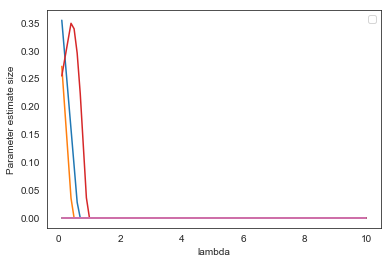

In [308]:

# checking that df includes needed columns
#estimates_lasso_df

# index columns to exclude lambda column value from variables to plot
lasso_varstoplot = list(estimates_lasso_df.columns[:7,])

# Checking type and making sure lambda column not included in varstoplot
#type(varstoplot)
#varstoplot

# Leave out variables with high values and throw off plot scale
#varstoplot.remove('property_crime_2')
#varstoplot.remove('property_crime_3')
#varstoplot.remove('property_crime_sqrt')

# Plot a line for each parameter.
for lasso_var in lasso_varstoplot:
    plt.plot(estimates_lasso_df['lambda_lasso'], estimates_lasso_df[lasso_var])
    labels.append(lasso_var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels_lasso)
plt.show()

## Logistic Regression: SKLearn

Will specify Ridge Regression with l2 argument because of identified high multicollinearity.

In [324]:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# take out string related columns to avoid errors and remove all other added columns as well
df_outliers_removed_sklearn_logistic_regression = df_outliers_removed.drop(columns=['city', 'violent_crime', 'rape_2', 'pop_size',
                                                                       'murder_manslaughter_cat', 'robbery_cat',
                                                                       'log_pop_size', 'outlier','log_robbery', 
                                                                       'log_aggravated_assault', 'property_crime_cat', 
                                                                       'rape_cat', 'pop_size_quantile',  'quantile_0-3',
                                                                       'murder_manslaughter', 'property_crime',
                                                                       'burglary', 'larceny_theft','mv_theft', 'arson_3'])


logistic_regr_columns = ['robbery', 'aggravated_assault']

X = df_outliers_removed_sklearn_logistic_regression[logistic_regr_columns]

y = df_outliers_removed_sklearn_logistic_regression['property_crime_above_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [325]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.60


In [326]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[40  8]
 [23  7]]


In [327]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.83      0.72        48
           1       0.47      0.23      0.31        30

   micro avg       0.60      0.60      0.60        78
   macro avg       0.55      0.53      0.52        78
weighted avg       0.57      0.60      0.56        78



# Conclusion:

This crime dataset had few features, so there was less of a need to use Lasso Regression to identify and select features.  However, there is very high multicollinearity, so Ridge Regression was a useful tool to reduce the impact of multicollinearity.